In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the dataset
df = pd.read_csv('final_cleaned_dataset.csv')

# Print original class distribution
print("Original class distribution:")
print(df['PerformanceScore_Encoded'].value_counts())
print()

# Check for non-numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(exclude=['number']).columns.tolist()

print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")

if 'Position' in df.columns and 'Position' not in categorical_cols:
    categorical_cols.append('Position')

if 'PerformanceScore_Encoded' in numeric_cols:
    numeric_cols.remove('PerformanceScore_Encoded')

# Remove categorical columns that are already one-hot encoded (True/False values)
true_categorical_cols = []
for col in categorical_cols:
    if df[col].nunique() > 2 or df[col].dtype == 'object':
        true_categorical_cols.append(col)

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), true_categorical_cols)
    ])

# Separate features and target variable
X = df.drop('PerformanceScore_Encoded', axis=1)
y = df['PerformanceScore_Encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Apply preprocessing
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

print(f"Transformed X_train shape: {X_train_scaled.shape}")

print("Training set class distribution before oversampling:")
print(Counter(y_train))
print()

# Function to train SVM and evaluate
def train_and_evaluate(X_train, y_train, X_test, y_test, model_name):
    # Train an SVM classifier
    svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
    svm.fit(X_train, y_train)

    # Make predictions
    y_pred = svm.predict(X_test)

    # Evaluate
    print(f"=== {model_name} ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print()

# 1. Train model without oversampling
print("Training SVM without oversampling...")
train_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, "No Oversampling")

# 2. Apply SMOTE oversampling
print("Applying SMOTE oversampling...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print("Training set class distribution after SMOTE:")
print(Counter(y_train_smote))
print()

train_and_evaluate(X_train_smote, y_train_smote, X_test_scaled, y_test, "SMOTE")

# 3. Apply ADASYN oversampling
print("Applying ADASYN oversampling...")
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_scaled, y_train)
print("Training set class distribution after ADASYN:")
print(Counter(y_train_adasyn))
print()

train_and_evaluate(X_train_adasyn, y_train_adasyn, X_test_scaled, y_test, "ADASYN")

# 4. Fine-tuned SVM with SMOTE (to reduce overfitting)
print("Training fine-tuned SVM with SMOTE...")
svm_tuned = SVC(kernel='rbf', C=0.1, gamma='auto', probability=True)
svm_tuned.fit(X_train_smote, y_train_smote)
y_pred_tuned = svm_tuned.predict(X_test_scaled)

print("=== Fine-tuned SVM with SMOTE ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))

Original class distribution:
PerformanceScore_Encoded
3    243
4     37
2     18
1     13
Name: count, dtype: int64

Numeric columns: 27
Categorical columns: 30
Transformed X_train shape: (248, 53)
Training set class distribution before oversampling:
Counter({3: 194, 4: 30, 2: 14, 1: 10})

Training SVM without oversampling...
=== No Oversampling ===
Confusion Matrix:
[[ 2  1  0  0]
 [ 0  3  1  0]
 [ 0  0 49  0]
 [ 0  0  7  0]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       0.75      0.75      0.75         4
           3       0.86      1.00      0.92        49
           4       0.00      0.00      0.00         7

    accuracy                           0.86        63
   macro avg       0.65      0.60      0.62        63
weighted avg       0.76      0.86      0.80        63


Applying SMOTE oversampling...
Training set class distribution after SMOTE:
Counter({3: 194, 4: 194, 2: 194, 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


=== SMOTE ===
Confusion Matrix:
[[ 2  1  0  0]
 [ 0  4  0  0]
 [ 0  0 33 16]
 [ 0  0  4  3]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       0.80      1.00      0.89         4
           3       0.89      0.67      0.77        49
           4       0.16      0.43      0.23         7

    accuracy                           0.67        63
   macro avg       0.71      0.69      0.67        63
weighted avg       0.81      0.67      0.72        63


Applying ADASYN oversampling...
Training set class distribution after ADASYN:
Counter({3: 194, 1: 194, 2: 193, 4: 192})

=== ADASYN ===
Confusion Matrix:
[[ 2  1  0  0]
 [ 0  4  0  0]
 [ 0  0 31 18]
 [ 0  0  3  4]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       0.80      1.00      0.89         4
           3       0.91      0.63      0.75  

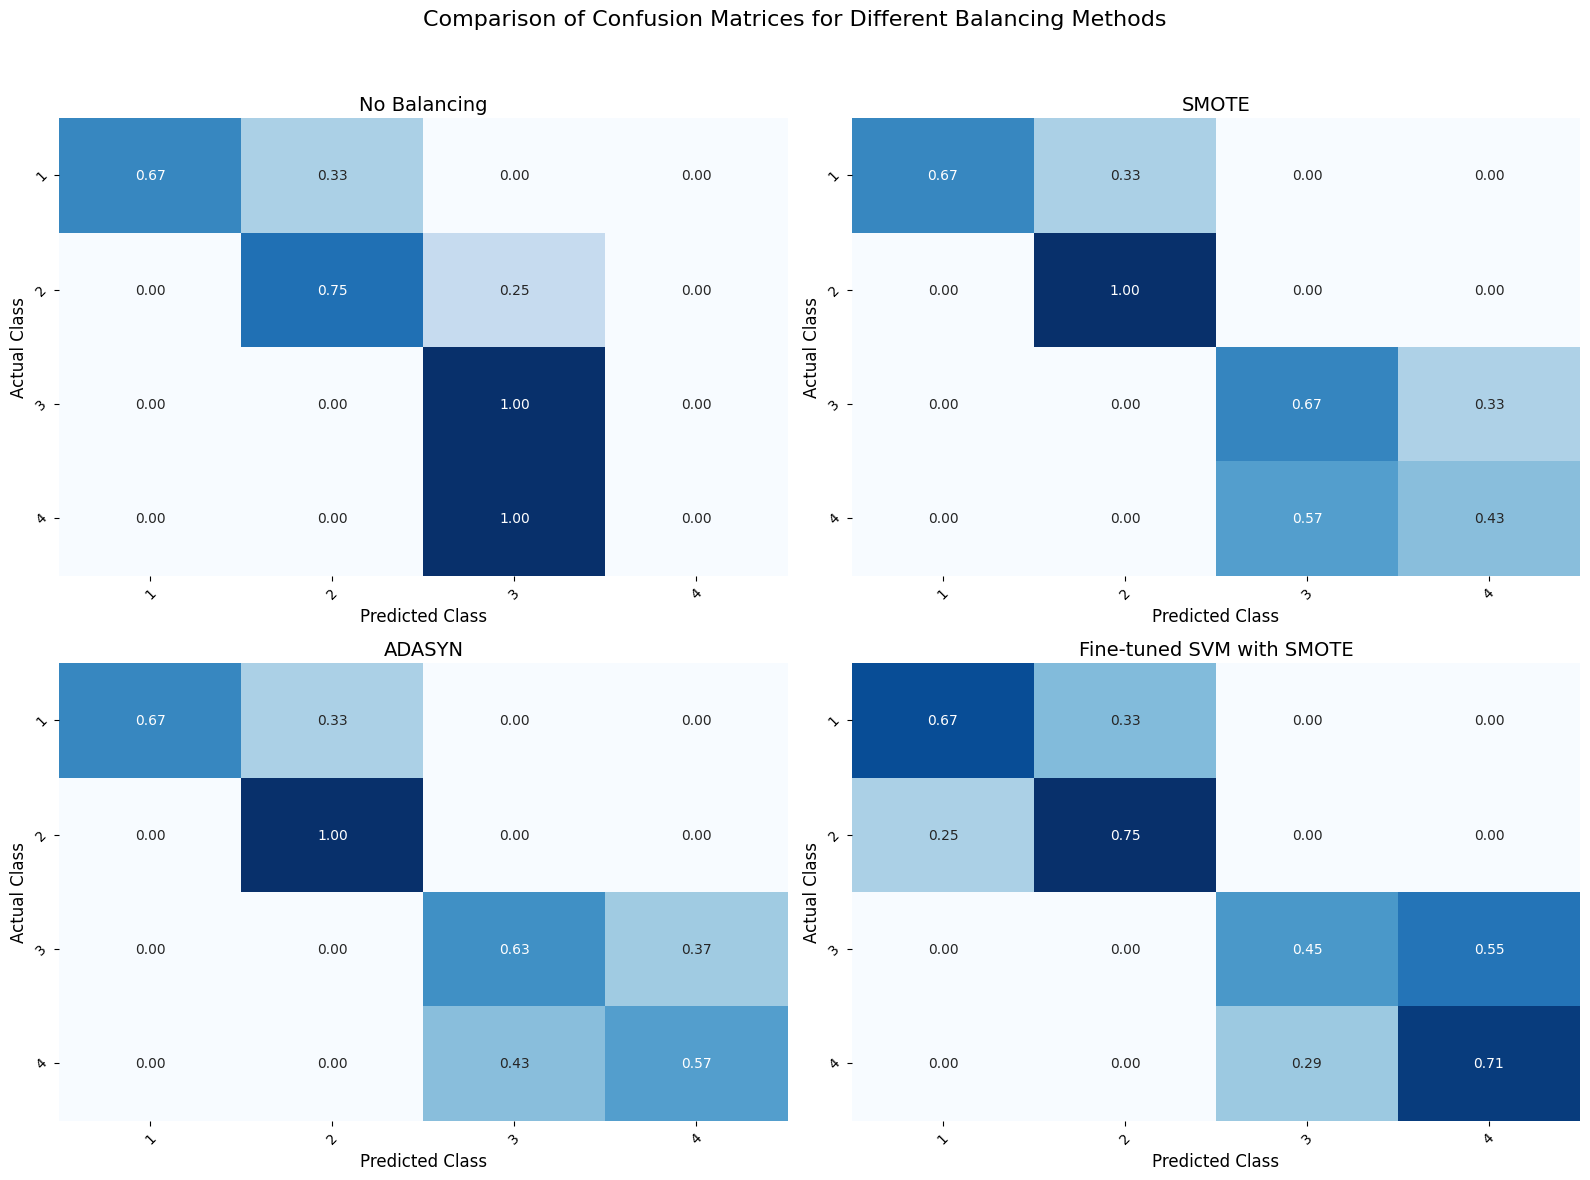

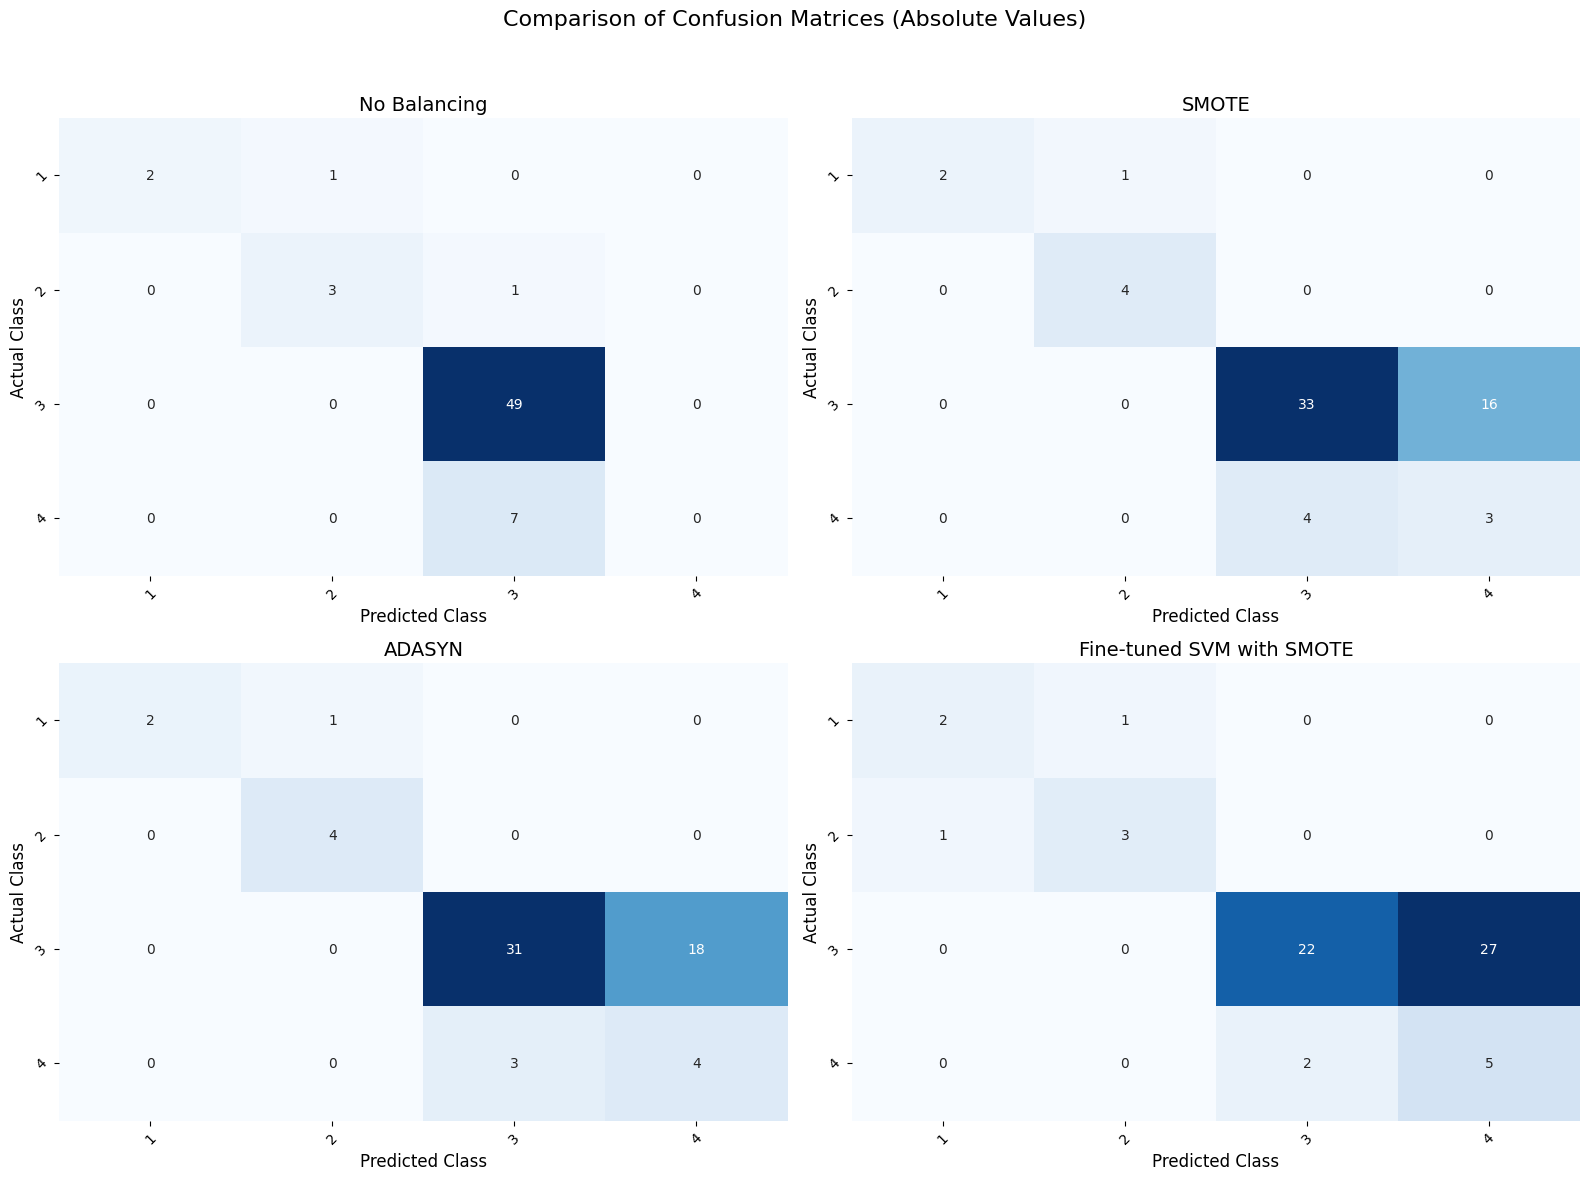

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to get the confusion matrix
def get_confusion_matrix(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)

# Getting confusion matrices for all methods
# Without balancing
svm_no_balance = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
svm_no_balance.fit(X_train_scaled, y_train)
y_pred_no_balance = svm_no_balance.predict(X_test_scaled)
cm_no_balance = get_confusion_matrix(y_test, y_pred_no_balance)

# SMOTE
svm_smote = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
svm_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = svm_smote.predict(X_test_scaled)
cm_smote = get_confusion_matrix(y_test, y_pred_smote)

# ADASYN
svm_adasyn = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
svm_adasyn.fit(X_train_adasyn, y_train_adasyn)
y_pred_adasyn = svm_adasyn.predict(X_test_scaled)
cm_adasyn = get_confusion_matrix(y_test, y_pred_adasyn)

# Fine-tuned SVM with SMOTE
svm_tuned = SVC(kernel='rbf', C=0.1, gamma='auto', probability=True)
svm_tuned.fit(X_train_smote, y_train_smote)
y_pred_tuned = svm_tuned.predict(X_test_scaled)
cm_tuned = get_confusion_matrix(y_test, y_pred_tuned)

# Creating visualization of confusion matrices
plt.figure(figsize=(16, 12))

# Define classes for labels
classes = sorted(np.unique(y))
titles = ['No Balancing', 'SMOTE', 'ADASYN', 'Fine-tuned SVM with SMOTE']
confusion_matrices = [cm_no_balance, cm_smote, cm_adasyn, cm_tuned]

# Normalize matrices for better visualization
normalized_matrices = []
for cm in confusion_matrices:
    normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    normalized_matrices.append(normalized_cm)

# Create subplots for each matrix
for i, (cm, title) in enumerate(zip(normalized_matrices, titles)):
    plt.subplot(2, 2, i + 1)

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes, cbar=False)

    # Add title and axis labels
    plt.title(title, fontsize=14)
    plt.ylabel('Actual Class', fontsize=12)
    plt.xlabel('Predicted Class', fontsize=12)

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

# Add main title
plt.suptitle('Comparison of Confusion Matrices for Different Balancing Methods', fontsize=16)

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the image
plt.savefig('Figure_5_1_confusion_matrices.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

# Additionally: create alternative visualization with absolute values
plt.figure(figsize=(16, 12))

for i, (cm, title) in enumerate(zip(confusion_matrices, titles)):
    plt.subplot(2, 2, i + 1)

    # Create heatmap with absolute values
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes, cbar=False)

    plt.title(title, fontsize=14)
    plt.ylabel('Actual Class', fontsize=12)
    plt.xlabel('Predicted Class', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

plt.suptitle('Comparison of Confusion Matrices (Absolute Values)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('Figure_5_1_confusion_matrices_absolute.png', dpi=300, bbox_inches='tight')
plt.show()

**ADASYN**

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import StandardScaler

# Load the original dataset
df = pd.read_csv('final_cleaned_dataset.csv')

print(f"Original dataset shape: {df.shape}")
print(f"Class distribution before ADASYN:")
print(df['PerformanceScore_Encoded'].value_counts())
print(df['PerformanceScore_Encoded'].value_counts(normalize=True).round(3) * 100)

# ========================
# Create all required features with correct names
# ========================

# List of consensus features we need to make sure exist in the final dataset
consensus_features = [
    'DaysLateLast30_MinMax',
    'EngagementSurvey_Scaled',
    'Tenure_Years_Scaled',
    'Absences_MinMax',
    'Salary_Scaled',
    'EmpSatisfaction_Scaled',
    'Age_Scaled',
    'EmploymentStatus_Encoded',
    'Sex_Encoded',
    'MaritalDesc_Married',
    'RaceDesc_Black or African American',
    'MaritalDesc_Single',
    'Position_Production Technician I',
    'Position_Production Technician II',
    'RecruitmentSource_LinkedIn'
]

# Create the two missing Position features
if 'Position' in df.columns:
    df['Position_Production Technician I'] = (df['Position'] == 'Production Technician I').astype(float)
    df['Position_Production Technician II'] = (df['Position'] == 'Production Technician II').astype(float)
else:
    print("Warning: 'Position' column not found. Creating dummy position columns.")
    df['Position_Production Technician I'] = 0.0
    df['Position_Production Technician II'] = 0.0

# Verify all other features exist or create them from raw data if needed
# This handles cases where we need to transform raw features into expected formats

# Check for _Scaled features and create them if they don't exist
for feature in ['EngagementSurvey', 'Tenure_Years', 'Salary', 'EmpSatisfaction', 'Age']:
    scaled_feature = f"{feature}_Scaled"
    if scaled_feature not in df.columns and feature in df.columns:
        # Apply Min-Max scaling to create _Scaled version
        df[scaled_feature] = (df[feature] - df[feature].min()) / (df[feature].max() - df[feature].min())
        print(f"Created {scaled_feature} from {feature}")

# Check for binary categorical features and create them if needed
if 'MaritalDesc' in df.columns:
    if 'MaritalDesc_Married' not in df.columns:
        df['MaritalDesc_Married'] = (df['MaritalDesc'] == 'Married').astype(float)
        print("Created MaritalDesc_Married")
    if 'MaritalDesc_Single' not in df.columns:
        df['MaritalDesc_Single'] = (df['MaritalDesc'] == 'Single').astype(float)
        print("Created MaritalDesc_Single")

if 'RaceDesc' in df.columns and 'RaceDesc_Black or African American' not in df.columns:
    df['RaceDesc_Black or African American'] = (df['RaceDesc'] == 'Black or African American').astype(float)
    print("Created RaceDesc_Black or African American")

if 'RecruitmentSource' in df.columns and 'RecruitmentSource_LinkedIn' not in df.columns:
    df['RecruitmentSource_LinkedIn'] = (df['RecruitmentSource'] == 'LinkedIn').astype(float)
    print("Created RecruitmentSource_LinkedIn")

# Create encoded features if needed
if 'Sex' in df.columns and 'Sex_Encoded' not in df.columns:
    df['Sex_Encoded'] = df['Sex'].map({'F': 0, 'M': 1})
    print("Created Sex_Encoded")

if 'EmploymentStatus' in df.columns and 'EmploymentStatus_Encoded' not in df.columns:
    df['EmploymentStatus_Encoded'] = df['EmploymentStatus'].map({'Active': 1, 'Terminated': 0})
    print("Created EmploymentStatus_Encoded")

# Create MinMax features if needed
if 'Absences' in df.columns and 'Absences_MinMax' not in df.columns:
    df['Absences_MinMax'] = (df['Absences'] - df['Absences'].min()) / (df['Absences'].max() - df['Absences'].min())
    print("Created Absences_MinMax")

if 'DaysLateLast30' in df.columns and 'DaysLateLast30_MinMax' not in df.columns:
    df['DaysLateLast30_MinMax'] = (df['DaysLateLast30'] - df['DaysLateLast30'].min()) / (df['DaysLateLast30'].max() - df['DaysLateLast30'].min())
    print("Created DaysLateLast30_MinMax")

# ========================
# Prepare data for ADASYN
# ========================

# Check which consensus features are actually available
available_features = [col for col in consensus_features if col in df.columns]
missing_features = [col for col in consensus_features if col not in df.columns]

if missing_features:
    print(f"\nWarning: The following features are still missing: {missing_features}")
    print("These features will not be used in the model.")

print(f"\nUsing {len(available_features)} consensus features: {available_features}")

# Separate target variable
y = df['PerformanceScore_Encoded']
X = df[available_features]  # Only use available consensus features

# ========================
# ADASYN Oversampling
# ========================

# Apply ADASYN
n_neighbors = min(5, min(y.value_counts()) - 1)  # k_neighbors must be <= n_samples - 1
print(f"Using n_neighbors = {n_neighbors} for ADASYN")

adasyn = ADASYN(random_state=42, n_neighbors=n_neighbors)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

print(f"\nADASYN dataset shape: {X_adasyn.shape}")
print(f"Class distribution after ADASYN:")
unique, counts = np.unique(y_adasyn, return_counts=True)
for class_label, count in zip(unique, counts):
    print(f"Class {class_label}: {count} ({count/len(y_adasyn)*100:.1f}%)")

# ========================
# Create final dataframe for saving
# ========================

# Create DataFrame with the ADASYN-generated data
adasyn_df = pd.DataFrame(X_adasyn, columns=available_features)
adasyn_df['PerformanceScore_Encoded'] = y_adasyn

# Save the ADASYN dataset to CSV
adasyn_df.to_csv('employee_data_adasyn.csv', index=False)

print("\nADASYN dataset has been created and saved successfully!")

Original dataset shape: (311, 57)
Class distribution before ADASYN:
PerformanceScore_Encoded
3    243
4     37
2     18
1     13
Name: count, dtype: int64
PerformanceScore_Encoded
3    78.1
4    11.9
2     5.8
1     4.2
Name: proportion, dtype: float64

Using 15 consensus features: ['DaysLateLast30_MinMax', 'EngagementSurvey_Scaled', 'Tenure_Years_Scaled', 'Absences_MinMax', 'Salary_Scaled', 'EmpSatisfaction_Scaled', 'Age_Scaled', 'EmploymentStatus_Encoded', 'Sex_Encoded', 'MaritalDesc_Married', 'RaceDesc_Black or African American', 'MaritalDesc_Single', 'Position_Production Technician I', 'Position_Production Technician II', 'RecruitmentSource_LinkedIn']
Using n_neighbors = 5 for ADASYN

ADASYN dataset shape: (959, 15)
Class distribution after ADASYN:
Class 1: 241 (25.1%)
Class 2: 240 (25.0%)
Class 3: 243 (25.3%)
Class 4: 235 (24.5%)

ADASYN dataset has been created and saved successfully!


**Model training**

In [ ]:
# SVM Training for Employee Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from google.colab import files
import io

'''# Upload the dataset in Google Colab
uploaded = files.upload()  # This will prompt you to upload your CSV file
file_name = list(uploaded.keys())[0]  # Get the filename of the uploaded file'''

# Read the dataset
df = pd.read_csv('employee_data_adasyn.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nSummary statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values count:")
print(df.isnull().sum())

# Convert string True/False to boolean for relevant columns
string_bool_columns = [col for col in df.columns if df[col].dtype == 'object' and
                       set(df[col].unique()).issubset({"True", "False"})]
for col in string_bool_columns:
    df[col] = df[col].map({"True": True, "False": False})

# Visualize distribution of potential target variables
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Assuming PerformanceScore_Encoded is the target variable
df['PerformanceScore_Encoded'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Distribution of Performance Scores')
axes[0].set_xlabel('Performance Score')
axes[0].set_ylabel('Count')

# Employment Status distribution
df['EmploymentStatus_Encoded'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('Distribution of Employment Status')
axes[1].set_xlabel('Employment Status')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Correlation analysis
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Define features and target variable - you can change the target as needed
# Using PerformanceScore_Encoded as the target here
X = df.drop('PerformanceScore_Encoded', axis=1)
y = df['PerformanceScore_Encoded']

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['bool', 'object']).columns.tolist()

print("\nNumerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

# Create an SVM pipeline with preprocessing
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=42))
])

# Define hyperparameters for grid search
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__kernel': ['linear', 'rbf', 'poly']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
print("\nModel Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix visualization
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

# Save the best model (optional)
import pickle
with open('svm_employee_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)
print("\nModel saved as 'svm_employee_model.pkl'")

# Download the model (in Colab)
files.download('svm_employee_model.pkl')

# Feature importance analysis (using coefficients for linear kernel)
if grid_search.best_params_['classifier__kernel'] == 'linear':
    feature_names = numerical_cols.copy()
    for name, ohe in preprocessor.transformers_:
        if name == 'cat':
            # Get the feature names from the one-hot encoder
            feature_names.extend(ohe.get_feature_names_out(categorical_cols))

    # Get the coefficients from the SVM model
    coefficients = best_model.named_steps['classifier'].coef_

    # For multiclass classification
    if len(coefficients.shape) > 1:
        # Take absolute value of coefficients and sum across classes
        importance = np.sum(np.abs(coefficients), axis=0)
    else:
        importance = np.abs(coefficients[0])

    # Create DataFrame for visualization
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    # Plot top 15 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Feature Importance (Linear SVM)')
    plt.tight_layout()
    plt.show()
else:
    print("\nFeature importance analysis is only available for linear kernel")

**Overfitting Detection**

In [ ]:
# Overfitting Detection for SVM Employee Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, roc_curve, auc, precision_recall_fscore_support,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle
from google.colab import files
import io
import warnings
warnings.filterwarnings('ignore')

# Upload the dataset and model in Google Colab
print("Upload your CSV dataset first:")
uploaded_data = files.upload()  # Upload the dataset
file_name = list(uploaded_data.keys())[0]

print("\nNow upload your saved SVM model:")
uploaded_model = files.upload()  # Upload the model
model_name = list(uploaded_model.keys())[0]

# Load the dataset
df = pd.read_csv(io.BytesIO(uploaded_data[file_name]))

# Convert string True/False to boolean for relevant columns
string_bool_columns = [col for col in df.columns if df[col].dtype == 'object' and
                       set(df[col].unique()).issubset({"True", "False"})]
for col in string_bool_columns:
    df[col] = df[col].map({"True": True, "False": False})

# Define features and target variable
X = df.drop('PerformanceScore_Encoded', axis=1)
y = df['PerformanceScore_Encoded']

# Load the trained model
with open(model_name, 'rb') as file:
    best_model = pickle.load(file)

print("\nModel loaded successfully!")

# Get the original data split that was used for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# ========================= 1. Comparing Metrics on Training and Test Sets =========================
def check_accuracy_gap():
    # Get predictions on training and test sets
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    accuracy_gap = train_accuracy - test_accuracy

    print("\n1. ACCURACY GAP ANALYSIS")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Accuracy Gap (Δ): {accuracy_gap:.4f}")

    if accuracy_gap > 0.1:
        print("⚠️ Potential overfitting detected! (Δ > 0.1)")
    else:
        print("✅ No significant overfitting detected based on accuracy gap (Δ ≤ 0.1)")

    # Visualization of accuracy comparison
    plt.figure(figsize=(8, 6))
    bars = plt.bar(['Training', 'Test'], [train_accuracy, test_accuracy], color=['#3498db', '#2ecc71'])
    plt.ylim(0, 1.1)
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison: Training vs Test')

    # Add text labels above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

    # Add a horizontal line for the threshold
    plt.axhline(y=train_accuracy - 0.1, color='r', linestyle='--', alpha=0.5)
    plt.text(1.05, train_accuracy - 0.1, 'Threshold (Δ = 0.1)', color='r', va='center')

    plt.tight_layout()
    plt.show()

    return train_accuracy, test_accuracy, accuracy_gap

# ========================= 2. Learning Curves Analysis =========================
def plot_learning_curves():
    print("\n2. LEARNING CURVES ANALYSIS")

    # Get the pipeline steps from the model
    preprocessor = best_model.named_steps['preprocessor']
    classifier = best_model.named_steps['classifier']

    # Create a new pipeline for learning curve evaluation
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Calculate learning curves
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, val_scores = learning_curve(
        pipeline, X, y, train_sizes=train_sizes,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy', random_state=42, n_jobs=-1
    )

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for validation set scores
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Calculate the gap between training and validation curves
    gap = train_mean - val_mean

    # NaN တန်ဖိုးများကို စစ်ဆေးရန်
    nan_mask = np.isnan(gap)
    if np.any(nan_mask):
        print(f"Warning: {np.sum(nan_mask)} NaN values detected in gap calculation")
        print("Only using non-NaN values for analysis")

        # NaN မဟုတ်သော စောင့်ကြည့်ထိန်းချုပ်မှုနောက်ဆုံးတန်ဖိုးကို ရှာပါ
        non_nan_indices = np.where(~np.isnan(gap))[0]
        if len(non_nan_indices) == 0:
            print("Error: All gap values are NaN. Unable to calculate metrics.")
            return 0, False, False

        # NaN မဟုတ်သော နောက်ဆုံးတန်ဖိုးကို အသုံးပြုပါ
        latest_valid_idx = np.max(non_nan_indices)
        latest_gap = gap[latest_valid_idx]

        # NaN မဟုတ်သော တန်ဖိုးများအတွက်သာ ပျမ်းမျှတွက်ချက်ပါ
        avg_gap = np.nanmean(gap)
        sum_gap = np.nansum(gap)

        # Converging ကိုလည်း NaN မဟုတ်သော တန်ဖိုးများအတွက်သာ တွက်ချက်ပါ
        if len(non_nan_indices) > 1:
            first_valid_idx = np.min(non_nan_indices)
            converging = gap[latest_valid_idx] < gap[first_valid_idx]
        else:
            converging = False
    else:
        # NaN တန်ဖိုးများ မရှိပါက ပုံမှန်အတိုင်း တွက်ချက်ပါ
        latest_gap = gap[-1]
        avg_gap = np.mean(gap)
        sum_gap = np.sum(gap)
        converging = gap[-1] < gap[0]

    # Determine if curves are stable (low standard deviation in later points)
    # NaN တန်ဖိုးများ၏ သက်ရောက်မှုကို ရှောင်ရှားရန် np.nanmean ကို အသုံးပြုပါ
    late_std_train = np.nanmean(train_std[-3:])
    late_std_val = np.nanmean(val_std[-3:])
    stable = late_std_train < 0.03 and late_std_val < 0.03

    # ရလဒ်များ ထုတ်ပြပါ
    print(f"Average gap between training and validation: {avg_gap:.4f}")
    print(f"Latest gap (at maximum training data): {latest_gap:.4f}")
    print(f"Sum of gaps across all training sizes: {sum_gap:.4f}")
    print(f"Are curves converging? {'Yes' if converging else 'No'}")
    print(f"Are curves stable? {'Yes' if stable else 'No'}")

    # နောက်ဆုံး gap ကို အသုံးပြု၍ ဆုံးဖြတ်ချက်ချပါ
    if latest_gap > 0.1:
        print("⚠️ Potential overfitting detected! (latest gap > 0.1)")
    else:
        print("✅ No significant overfitting detected based on learning curves (latest gap ≤ 0.1)")

    # Plot learning curves - NaN တန်ဖိုးများကို ဂရပ်တွင် ရှောင်ရှားရန်
    plt.figure(figsize=(10, 6))

    # NaN မဟုတ်သော တန်ဖိုးများကိုသာ ပလော့တင်ပါ
    valid_indices = ~np.isnan(train_mean) & ~np.isnan(val_mean)
    valid_train_sizes = train_sizes[valid_indices]
    valid_train_mean = train_mean[valid_indices]
    valid_train_std = train_std[valid_indices]
    valid_val_mean = val_mean[valid_indices]
    valid_val_std = val_std[valid_indices]

    plt.plot(valid_train_sizes, valid_train_mean, 'o-', color='#3498db', label='Training score')
    plt.fill_between(valid_train_sizes, valid_train_mean - valid_train_std,
                    valid_train_mean + valid_train_std, alpha=0.1, color='#3498db')

    plt.plot(valid_train_sizes, valid_val_mean, 'o-', color='#2ecc71', label='Cross-validation score')
    plt.fill_between(valid_train_sizes, valid_val_mean - valid_val_std,
                    valid_val_mean + valid_val_std, alpha=0.1, color='#2ecc71')

    plt.title('Learning Curves for SVM Model')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy Score')
    plt.grid(True)
    plt.legend(loc='best')

    # ဗဟိုကွာဟချက်စာသားကိုသာ ဖော်ပြပါ - အနီရောင်မြားကို ဖယ်ရှားထားပါသည်
    plt.annotate(
        f'Latest Gap: {latest_gap:.4f}\nAvg Gap: {avg_gap:.4f}',
        xy=(0.5, 0.5), xycoords='axes fraction',
        bbox=dict(boxstyle="round,pad=0.3", fc="#f8f9fa", ec="#343a40", alpha=0.8)
    )

    # အနီရောင်မြားဖော်ပြချက်ကို ဖယ်ရှားပါ - အောက်ပါကုဒ်များကို ဖယ်ရှားထားပါသည်
    # last_idx = len(valid_train_sizes) - 1
    # last_train_size = valid_train_sizes[last_idx]
    # last_train_score = valid_train_mean[last_idx]
    # last_val_score = valid_val_mean[last_idx]
    # plt.plot([last_train_size, last_train_size], [last_val_score, last_train_score],
    #         'r--', linewidth=2)
    # plt.annotate(
    #     f'Latest Gap: {latest_gap:.4f}',
    #     xy=(last_train_size, (last_val_score + last_train_score)/2),
    #     xytext=(last_train_size-0.15, (last_val_score + last_train_score)/2),
    #     arrowprops=dict(arrowstyle="->", color='red'),
    #     color='red'
    # )

    plt.tight_layout()
    plt.show()

    # နောက်ဆုံး gap ကို ပြန်ပေးပါ
    return latest_gap, converging, stable


# ========================= 3. ROC Analysis and AUC Comparison =========================
def perform_roc_analysis():
    print("\n3. ROC ANALYSIS AND AUC COMPARISON")

    # Get the number of classes
    n_classes = len(np.unique(y))

    # Binarize the output for multi-class ROC analysis
    y_train_bin = label_binarize(y_train, classes=sorted(np.unique(y)))
    y_test_bin = label_binarize(y_test, classes=sorted(np.unique(y)))

    # Get probability predictions
    y_train_score = best_model.predict_proba(X_train)
    y_test_score = best_model.predict_proba(X_test)

    # Calculate ROC curve and AUC for each class
    fpr_train = dict()
    tpr_train = dict()
    roc_auc_train = dict()

    fpr_test = dict()
    tpr_test = dict()
    roc_auc_test = dict()

    for i in range(n_classes):
        fpr_train[i], tpr_train[i], _ = roc_curve(y_train_bin[:, i], y_train_score[:, i])
        roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

        fpr_test[i], tpr_test[i], _ = roc_curve(y_test_bin[:, i], y_test_score[:, i])
        roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

    # Calculate macro-average AUC
    macro_auc_train = np.mean([roc_auc_train[i] for i in range(n_classes)])
    macro_auc_test = np.mean([roc_auc_test[i] for i in range(n_classes)])
    auc_gap = macro_auc_train - macro_auc_test

    print(f"Training Set Macro-AUC: {macro_auc_train:.4f}")
    print(f"Test Set Macro-AUC: {macro_auc_test:.4f}")
    print(f"AUC Gap (Δ): {auc_gap:.4f}")

    if auc_gap > 0.05:
        print("⚠️ Potential overfitting detected! (ΔAUC > 0.05)")
    else:
        print("✅ No significant overfitting detected based on AUC gap (ΔAUC ≤ 0.05)")

    # Plot ROC curves
    plt.figure(figsize=(12, 8))

    # Plot macro-average ROC curve for training
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Plot class-specific ROC curves
    colors = plt.cm.tab10(np.linspace(0, 1, n_classes))

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2, linestyle='-',
                 label=f'Train ROC class {i+1} (AUC = {roc_auc_train[i]:.3f})')

        plt.plot(fpr_test[i], tpr_test[i], color=color, lw=2, linestyle='--',
                 label=f'Test ROC class {i+1} (AUC = {roc_auc_test[i]:.3f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Training and Test Sets')
    plt.legend(loc="lower right")

    # Add annotation for the gap
    plt.annotate(f'Macro AUC Gap: {auc_gap:.4f}',
                xy=(0.5, 0.2), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="#f8f9fa", ec="#343a40", alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Bar chart comparing class-specific AUCs
    plt.figure(figsize=(10, 6))

    class_labels = [f'Class {i+1}' for i in range(n_classes)]
    x = np.arange(len(class_labels))
    width = 0.35

    train_aucs = [roc_auc_train[i] for i in range(n_classes)]
    test_aucs = [roc_auc_test[i] for i in range(n_classes)]

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, train_aucs, width, label='Training', color='#3498db')
    bars2 = ax.bar(x + width/2, test_aucs, width, label='Test', color='#2ecc71')

    ax.set_ylim(0, 1.1)
    ax.set_ylabel('AUC')
    ax.set_title('Class-Specific AUC Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(class_labels)
    ax.legend()

    # Add AUC gap annotations
    for i in range(n_classes):
        gap = train_aucs[i] - test_aucs[i]
        ax.annotate(f'Δ={gap:.3f}',
                   xy=(i, max(train_aucs[i], test_aucs[i]) + 0.05),
                   ha='center', va='bottom',
                   color='red' if gap > 0.05 else 'green')

    plt.tight_layout()
    plt.show()

    return macro_auc_train, macro_auc_test, auc_gap

# ========================= 4. Class-Specific Metrics Analysis =========================
def analyze_class_metrics():
    print("\n4. CLASS-SPECIFIC METRICS ANALYSIS")

    # Get predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate metrics for training set
    precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(y_train, y_train_pred, average=None)

    # Calculate metrics for test set
    precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average=None)

    # Calculate differences
    precision_diff = precision_train - precision_test
    recall_diff = recall_train - recall_test
    f1_diff = f1_train - f1_test

    # Check for overfitting in each class
    classes = sorted(np.unique(y))

    # Print class-specific metrics
    print("\nClass-specific metrics differences (Training - Test):")
    print("Class\tPrecision Δ\tRecall Δ\tF1 Δ")

    for i, class_label in enumerate(classes):
        print(f"{class_label}\t{precision_diff[i]:.4f}\t\t{recall_diff[i]:.4f}\t\t{f1_diff[i]:.4f}")

    # Identify classes with significant overfitting
    overfit_classes = []

    for i, class_label in enumerate(classes):
        if abs(precision_diff[i]) > 0.1 or abs(recall_diff[i]) > 0.1 or abs(f1_diff[i]) > 0.1:
            overfit_classes.append(class_label)

    if overfit_classes:
        print(f"\n⚠️ Potential class-specific overfitting detected in classes: {overfit_classes}")
    else:
        print("\n✅ No significant class-specific overfitting detected")

    # Create a heatmap of metric differences
    metrics_diff = pd.DataFrame({
        'Class': classes,
        'Precision Δ': precision_diff,
        'Recall Δ': recall_diff,
        'F1 Δ': f1_diff
    })

    metrics_diff_pivot = metrics_diff.melt(id_vars=['Class'], var_name='Metric', value_name='Difference')
    pivot_table = metrics_diff_pivot.pivot(index='Class', columns='Metric', values='Difference')

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, cmap='RdBu_r', center=0, fmt='.3f', cbar_kws={'label': 'Difference (Train - Test)'})
    plt.title('Class-Specific Metrics Differences (Training - Test)')
    plt.tight_layout()
    plt.show()

    return metrics_diff

# ========================= 5. Prediction Confidence Analysis =========================
def analyze_prediction_confidence():
    print("\n5. PREDICTION CONFIDENCE ANALYSIS")

    # Get probability predictions
    y_train_proba = best_model.predict_proba(X_train)
    y_test_proba = best_model.predict_proba(X_test)

    # Get the max probability for each prediction (confidence)
    train_confidence = np.max(y_train_proba, axis=1)
    test_confidence = np.max(y_test_proba, axis=1)

    # Calculate high confidence proportions
    high_conf_threshold = 0.8
    train_high_conf = np.mean(train_confidence >= high_conf_threshold)
    test_high_conf = np.mean(test_confidence >= high_conf_threshold)

    print(f"Proportion of high confidence (>{high_conf_threshold}) predictions:")
    print(f"Training set: {train_high_conf:.4f}")
    print(f"Test set: {test_high_conf:.4f}")
    print(f"Difference: {train_high_conf - test_high_conf:.4f}")

    # Decide if there's a confidence gap indicating overfitting
    conf_gap = train_high_conf - test_high_conf

    if conf_gap > 0.1:
        print("⚠️ Potential overfitting detected! (confidence gap > 0.1)")
    else:
        print("✅ No significant overfitting detected based on prediction confidence")

    # Plot confidence histograms
    plt.figure(figsize=(12, 6))

    # Training set confidence histogram
    plt.subplot(1, 2, 1)
    plt.hist(train_confidence, bins=20, alpha=0.7, color='#3498db')
    plt.axvline(x=high_conf_threshold, color='r', linestyle='--')
    plt.title(f'Training Set Confidence\nHigh Conf: {train_high_conf:.4f}')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Count')

    # Test set confidence histogram
    plt.subplot(1, 2, 2)
    plt.hist(test_confidence, bins=20, alpha=0.7, color='#2ecc71')
    plt.axvline(x=high_conf_threshold, color='r', linestyle='--')
    plt.title(f'Test Set Confidence\nHigh Conf: {test_high_conf:.4f}')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

    # Compare overall confidence distributions
    plt.figure(figsize=(10, 6))
    sns.kdeplot(train_confidence, label='Training', color='#3498db')
    sns.kdeplot(test_confidence, label='Test', color='#2ecc71')
    plt.axvline(x=high_conf_threshold, color='r', linestyle='--', label=f'Threshold ({high_conf_threshold})')
    plt.title('Prediction Confidence Distribution')
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return train_high_conf, test_high_conf, conf_gap

# ========================= 6. Regularization Parameter Analysis =========================
def analyze_regularization_parameter():
    print("\n6. REGULARIZATION PARAMETER ANALYSIS")

    # Identify the classifier and preprocessor from the pipeline
    preprocessor = best_model.named_steps['preprocessor']
    best_C = best_model.named_steps['classifier'].C

    print(f"Current C parameter value: {best_C}")

    # Define a range of C values to test
    C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

    # Scores containers
    train_scores = []
    test_scores = []

    for C in C_values:
        # Create a new SVM with the current C value
        svm = SVC(C=C, probability=True, random_state=42, kernel=best_model.named_steps['classifier'].kernel)

        # Create a pipeline with the same preprocessor
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', svm)
        ])

        # Fit the model
        pipeline.fit(X_train, y_train)

        # Get scores
        train_score = pipeline.score(X_train, y_train)
        test_score = pipeline.score(X_test, y_test)

        train_scores.append(train_score)
        test_scores.append(test_score)

    # Convert C values to strings for plotting
    C_values_str = [str(C) for C in C_values]

    # Find the index of the best C value in our list
    best_C_idx = C_values.index(best_C) if best_C in C_values else -1

    # Plot the regularization parameter curve
    plt.figure(figsize=(10, 6))
    plt.plot(C_values_str, train_scores, 'o-', color='#3498db', label='Training score')
    plt.plot(C_values_str, test_scores, 'o-', color='#2ecc71', label='Test score')

    # Mark the current C value
    if best_C_idx != -1:
        plt.axvline(x=best_C_idx, color='r', linestyle='--', label=f'Current C={best_C}')

    # Calculate the gaps
    gaps = np.array(train_scores) - np.array(test_scores)

    # Find the C with minimum gap
    min_gap_idx = np.argmin(gaps)
    min_gap_C = C_values[min_gap_idx]

    # Find the C with maximum test score
    max_test_idx = np.argmax(test_scores)
    max_test_C = C_values[max_test_idx]

    plt.title('Effect of C Parameter on Model Performance')
    plt.xlabel('C Parameter (log scale)')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')

    # Add annotations
    plt.annotate(f'Min Gap C={min_gap_C}',
                xy=(C_values_str[min_gap_idx], test_scores[min_gap_idx]),
                xytext=(0, 20), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

    plt.annotate(f'Max Test Score C={max_test_C}',
                xy=(C_values_str[max_test_idx], test_scores[max_test_idx]),
                xytext=(0, -30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

    # Add horizontal lines for each gap
    for i, (C, gap) in enumerate(zip(C_values_str, gaps)):
        if i % 2 == 0:  # Add for every other C value to avoid clutter
            plt.plot([i, i], [test_scores[i], train_scores[i]], 'k-', alpha=0.3)
            plt.text(i, (test_scores[i] + train_scores[i])/2, f'Δ={gap:.3f}', ha='right')

    plt.tight_layout()
    plt.show()

    # Recommendations
    print(f"\nC parameter recommendations:")
    print(f"- Minimum overfitting gap at C={min_gap_C}")
    print(f"- Maximum test score at C={max_test_C}")

    if best_C != min_gap_C and best_C != max_test_C:
        if min_gap_C == max_test_C:
            print(f"⚠️ Consider changing C from {best_C} to {min_gap_C} for better generalization and performance")
        else:
            print(f"⚠️ Consider changing C from {best_C} to either:")
            print(f"   - {min_gap_C} for minimum overfitting")
            print(f"   - {max_test_C} for maximum test performance")
    else:
        print("✅ Current C parameter is optimal")

    return train_scores, test_scores, C_values, best_C, min_gap_C, max_test_C

# ========================= 7. Cross-Validation Stability Assessment =========================
def assess_cv_stability():
    print("\n7. CROSS-VALIDATION STABILITY ASSESSMENT")

    # Define cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Get the classifier and preprocessor from the pipeline
    classifier = best_model.named_steps['classifier']
    preprocessor = best_model.named_steps['preprocessor']

    # Create a new pipeline for cross-validation
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

    # Calculate stability metrics
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)
    cv_range = np.max(cv_scores) - np.min(cv_scores)

    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean: {cv_mean:.4f}")
    print(f"Standard deviation: {cv_std:.4f}")
    print(f"Range: {cv_range:.4f}")

    # Evaluate stability
    if cv_std > 0.05:
        print("⚠️ High variance across folds detected (std > 0.05)")
    else:
        print("✅ Model is stable across cross-validation folds (std ≤ 0.05)")

    # Visualize the cross-validation results
    plt.figure(figsize=(10, 6))

    # Plot each fold score
    plt.bar(range(1, len(cv_scores) + 1), cv_scores, color='#3498db', alpha=0.7)

    # Add mean line
    plt.axhline(y=cv_mean, color='r', linestyle='-', label=f'Mean: {cv_mean:.4f}')

    # Add std bounds
    plt.axhline(y=cv_mean + cv_std, color='r', linestyle='--', alpha=0.5,
                label=f'Std: ±{cv_std:.4f}')
    plt.axhline(y=cv_mean - cv_std, color='r', linestyle='--', alpha=0.5)

    plt.title('Cross-Validation Stability Assessment')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, len(cv_scores) + 1))
    plt.ylim(0.5, 1.0)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return cv_mean, cv_std, cv_range

# ========================= MAIN EXECUTION FUNCTION =========================
def check_overfitting():
    """Perform comprehensive overfitting analysis on the model"""
    print("=" * 80)
    print("COMPREHENSIVE OVERFITTING ANALYSIS")
    print("=" * 80)

    # Run all analyses
    train_acc, test_acc, acc_gap = check_accuracy_gap()
    avg_gap, converging, stable = plot_learning_curves()
    macro_auc_train, macro_auc_test, auc_gap = perform_roc_analysis()
    metrics_diff = analyze_class_metrics()
    train_high_conf, test_high_conf, conf_gap = analyze_prediction_confidence()
    train_scores, test_scores, C_values, best_C, min_gap_C, max_test_C = analyze_regularization_parameter()
    cv_mean, cv_std, cv_range = assess_cv_stability()

    # Generate a summary report
    print("\n" + "=" * 80)
    print("OVERFITTING ANALYSIS SUMMARY")
    print("=" * 80)

    overfitting_indicators = [
        ("Accuracy Gap", acc_gap > 0.1, acc_gap),
        ("Learning Curve Gap", avg_gap > 0.1, avg_gap),
        ("AUC Gap", auc_gap > 0.05, auc_gap),
        ("Confidence Gap", conf_gap > 0.1, conf_gap),
        ("Cross-validation Stability", cv_std > 0.05, cv_std)
    ]

    # Count how many indicators suggest overfitting
    overfitting_count = sum(1 for _, is_overfitting, _ in overfitting_indicators if is_overfitting)

    # Print summary table
    print("\nOverfitting Indicators:")
    print("-" * 60)
    print(f"{'Indicator':<25} {'Value':<10} {'Status':<10}")
    print("-" * 60)

    for indicator, is_overfitting, value in overfitting_indicators:
        status = "⚠️ ISSUE" if is_overfitting else "✅ OK"
        print(f"{indicator:<25} {value:.4f}     {status}")

    print("-" * 60)

    # Overall assessment
    if overfitting_count == 0:
        print("\n🎉 OVERALL ASSESSMENT: No significant overfitting detected")
        print("The model generalizes well to unseen data.")
    elif overfitting_count <= 2:
        print("\n⚠️ OVERALL ASSESSMENT: Mild overfitting detected")
        print("The model shows some signs of overfitting but may still be acceptable depending on the use case.")
    else:
        print("\n❌ OVERALL ASSESSMENT: Significant overfitting detected")
        print("The model is likely overfitting the training data and may not generalize well.")

    # Recommendations
    print("\nRECOMMENDATIONS:")

    if overfitting_count > 0:
        print("1. Consider adjusting the regularization parameter:")
        print(f"   - Current C: {best_C}")
        print(f"   - Recommended C for minimizing overfitting: {min_gap_C}")
        print(f"   - Recommended C for maximizing test performance: {max_test_C}")

        print("\n2. Other techniques to try:")
        print("   - Increase training data or perform data augmentation")
        print("   - Feature selection to reduce model complexity")
        print("   - Ensemble methods (e.g., bagging) to reduce variance")
        print("   - Try a simpler kernel (e.g., linear if using rbf)")
    else:
        print("1. The model appears to be well-tuned.")
        print("2. You may want to explore if a simpler model could achieve similar performance.")
        print("3. Continue monitoring for overfitting when the model is deployed and used on new data.")

# Run the full analysis
check_overfitting()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the dataset
df = pd.read_csv('final_cleaned_dataset.csv')

# Print original class distribution
print("Original class distribution:")
print(df['PerformanceScore_Encoded'].value_counts())
print()

# Check for non-numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(exclude=['number']).columns.tolist()

print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")

if 'Position' in df.columns and 'Position' not in categorical_cols:
    categorical_cols.append('Position')

if 'PerformanceScore_Encoded' in numeric_cols:
    numeric_cols.remove('PerformanceScore_Encoded')

# Remove categorical columns that are already one-hot encoded (True/False values)
true_categorical_cols = []
for col in categorical_cols:
    if df[col].nunique() > 2 or df[col].dtype == 'object':
        true_categorical_cols.append(col)

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), true_categorical_cols)
    ])

# Separate features and target variable
X = df.drop('PerformanceScore_Encoded', axis=1)
y = df['PerformanceScore_Encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Apply preprocessing
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

print(f"Transformed X_train shape: {X_train_scaled.shape}")

print("Training set class distribution before oversampling:")
print(Counter(y_train))
print()

# Function to train SVM and evaluate
def train_and_evaluate(X_train, y_train, X_test, y_test, model_name):
    # Train an SVM classifier
    svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
    svm.fit(X_train, y_train)

    # Make predictions
    y_pred = svm.predict(X_test)

    # Evaluate
    print(f"=== {model_name} ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print()

# 1. Train model without oversampling
print("Training SVM without oversampling...")
train_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, "No Oversampling")

# 2. Apply SMOTE oversampling
print("Applying SMOTE oversampling...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print("Training set class distribution after SMOTE:")
print(Counter(y_train_smote))
print()

train_and_evaluate(X_train_smote, y_train_smote, X_test_scaled, y_test, "SMOTE")

# 3. Apply ADASYN oversampling
print("Applying ADASYN oversampling...")
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_scaled, y_train)
print("Training set class distribution after ADASYN:")
print(Counter(y_train_adasyn))
print()

train_and_evaluate(X_train_adasyn, y_train_adasyn, X_test_scaled, y_test, "ADASYN")

# 4. Fine-tuned SVM with SMOTE (to reduce overfitting)
print("Training fine-tuned SVM with SMOTE...")
svm_tuned = SVC(kernel='rbf', C=0.1, gamma='auto', probability=True)
svm_tuned.fit(X_train_smote, y_train_smote)
y_pred_tuned = svm_tuned.predict(X_test_scaled)

print("=== Fine-tuned SVM with SMOTE ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))

**Testing with ADASYN**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

# Set random seed for reproducibility
np.random.seed(42)

# =====================
# Load the oversampled dataset
# =====================
# You can use either the SMOTE or ADASYN dataset
# Uncomment the one you want to use:

# dataset_path = 'employee_data_smote.csv'
dataset_path = 'employee_data_adasyn.csv'
print(f"Loading dataset from: {dataset_path}")

df = pd.read_csv(dataset_path)
print(f"Dataset shape: {df.shape}")
print(f"Class distribution:")
print(df['PerformanceScore_Encoded'].value_counts())
print(df['PerformanceScore_Encoded'].value_counts(normalize=True).round(3) * 100)

# =====================
# Prepare data for training
# =====================
# Separate target variable
y = df['PerformanceScore_Encoded']
X = df.drop('PerformanceScore_Encoded', axis=1)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# =====================
# Create SVM model with hyperparameter tuning
# =====================
# Create a pipeline with scaling and SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, random_state=42))
])

# Define hyperparameter grid to search
param_grid = {
    'svm__C': [0.1, 0.5, 1.0, 5.0, 10.0],        # Regularization parameter
    'svm__gamma': ['scale', 'auto', 0.1, 0.01],  # Kernel coefficient
    'svm__kernel': ['rbf', 'linear']             # Kernel type
}

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create grid search with cross-validation
grid_search = GridSearchCV(
    pipeline, param_grid, cv=cv, scoring='f1_macro',
    verbose=1, n_jobs=-1  # Use all available cores
)

print("\nPerforming grid search for best hyperparameters...")
grid_search.fit(X_train, y_train)

# Print best parameters
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the best model
best_svm = grid_search.best_estimator_

# =====================
# Evaluate the model
# =====================
# Make predictions on test set
y_pred = best_svm.predict(X_test)
y_pred_proba = best_svm.predict_proba(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest set accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# =====================
# Visualizations
# =====================
# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('svm_confusion_matrix.png')
plt.show()

# Plot classification report as heatmap
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0)

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:, :3], annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Classification Report Heatmap')
plt.savefig('svm_classification_report.png')
plt.show()

# =====================
# Save the model
# =====================
import joblib

# Save the trained model
joblib.dump(best_svm, 'best_svm_model.pkl')
print("\nBest SVM model saved as 'best_svm_model.pkl'")

# =====================
# Analysis for moderate overfitting
# =====================
print("\nChecking for potential overfitting:")

# Compare training vs test performance
train_pred = best_svm.predict(X_train)
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy

print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Testing accuracy: {test_accuracy:.4f}")
print(f"Difference: {train_accuracy - test_accuracy:.4f}")

if train_accuracy - test_accuracy > 0.05:
    print("WARNING: Potential overfitting detected (difference > 0.05)")
    print("Consider using a more restrictive C value or collecting more data.")
else:
    print("Model does not show signs of significant overfitting.")

# =====================
# Feature importance (for linear kernel only)
# =====================
if 'linear' in str(best_svm.named_steps['svm']):
    # Get feature importance for linear SVM
    importance = best_svm.named_steps['svm'].coef_

    # Create a DataFrame for feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': np.mean(np.abs(importance), axis=0)
    })

    # Sort by importance
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    # Plot top 15 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Most Important Features (Linear SVM)')
    plt.tight_layout()
    plt.savefig('svm_feature_importance.png')
    plt.show()

    print("\nTop 5 most important features:")
    print(feature_importance.head(5))
else:
    print("\nFeature importance is only available for linear kernel.")
    print(f"Current kernel: {best_svm.named_steps['svm'].kernel}")

print("\nSVM training and evaluation completed!")

In [ ]:
# Overfitting Detection for SVM Employee Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, roc_curve, auc, precision_recall_fscore_support,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle
from google.colab import files
import io
import warnings
warnings.filterwarnings('ignore')

# Upload the dataset and model in Google Colab
print("Upload your CSV dataset first:")
uploaded_data = files.upload()  # Upload the dataset
file_name = list(uploaded_data.keys())[0]

print("\nNow upload your saved SVM model:")
uploaded_model = files.upload()  # Upload the model
model_name = list(uploaded_model.keys())[0]

# Load the dataset
df = pd.read_csv(io.BytesIO(uploaded_data[file_name]))

# Convert string True/False to boolean for relevant columns
string_bool_columns = [col for col in df.columns if df[col].dtype == 'object' and
                       set(df[col].unique()).issubset({"True", "False"})]
for col in string_bool_columns:
    df[col] = df[col].map({"True": True, "False": False})

# Define features and target variable
X = df.drop('PerformanceScore_Encoded', axis=1)
y = df['PerformanceScore_Encoded']

# Load the trained model
with open(model_name, 'rb') as file:
    best_model = pickle.load(file)

print("\nModel loaded successfully!")
print(f"Model type: {type(best_model)}")
print(f"Pipeline steps: {best_model.named_steps.keys()}")
print(f"SVM kernel: {best_model.named_steps['classifier'].kernel}")
print(f"SVM C parameter: {best_model.named_steps['classifier'].C}")
print(f"SVM gamma parameter: {best_model.named_steps['classifier'].gamma if hasattr(best_model.named_steps['classifier'], 'gamma') else 'auto'}")

# Get the original data split that was used for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set size: {X_test.shape[0]} samples, {X_test.shape[1]} features")

# Print class distribution
train_class_dist = pd.Series(y_train).value_counts(normalize=True)
test_class_dist = pd.Series(y_test).value_counts(normalize=True)
print("\nClass distribution:")
print("Training set:")
for cls, pct in train_class_dist.items():
    print(f"  Class {cls}: {pct:.2%} ({sum(y_train == cls)} samples)")
print("Test set:")
for cls, pct in test_class_dist.items():
    print(f"  Class {cls}: {pct:.2%} ({sum(y_test == cls)} samples)")

# ========================= 1. Comparing Metrics on Training and Test Sets =========================
def check_accuracy_gap():
    # Get predictions on training and test sets
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    accuracy_gap = train_accuracy - test_accuracy

    print("\n1. ACCURACY GAP ANALYSIS")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Accuracy Gap (Δ): {accuracy_gap:.4f}")

    # More detailed analysis
    print("\nDetailed Per-Class Accuracy Analysis:")
    classes = sorted(np.unique(y))

    print(f"{'Class':<10} {'Train Acc':<10} {'Test Acc':<10} {'Gap':<10} {'Status':<10}")
    print("-" * 50)

    for cls in classes:
        # Calculate per-class accuracy
        train_cls_acc = accuracy_score(y_train[y_train == cls], y_train_pred[y_train == cls])
        test_cls_acc = accuracy_score(y_test[y_test == cls], y_test_pred[y_test == cls])
        cls_gap = train_cls_acc - test_cls_acc

        status = "⚠️ Issue" if cls_gap > 0.1 else "✅ OK"
        print(f"{cls:<10} {train_cls_acc:.4f}     {test_cls_acc:.4f}     {cls_gap:.4f}     {status}")

    # Add confusion matrices
    print("\nTraining Set Confusion Matrix:")
    train_cm = confusion_matrix(y_train, y_train_pred)
    print(pd.DataFrame(train_cm, index=classes, columns=classes))

    print("\nTest Set Confusion Matrix:")
    test_cm = confusion_matrix(y_test, y_test_pred)
    print(pd.DataFrame(test_cm, index=classes, columns=classes))

    if accuracy_gap > 0.1:
        print("\n⚠️ Potential overfitting detected! (Δ > 0.1)")
        print(f"   The model performs {accuracy_gap:.2%} better on training data compared to test data.")
        print("   This suggests the model may have learned noise or patterns specific to the training data.")
    else:
        print("\n✅ No significant overfitting detected based on accuracy gap (Δ ≤ 0.1)")
        print(f"   The gap of {accuracy_gap:.2%} is within acceptable limits for generalization.")

    # Visualization of accuracy comparison
    plt.figure(figsize=(8, 6))
    bars = plt.bar(['Training', 'Test'], [train_accuracy, test_accuracy], color=['#3498db', '#2ecc71'])
    plt.ylim(0, 1.1)
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison: Training vs Test')

    # Add text labels above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

    # Add a horizontal line for the threshold
    plt.axhline(y=train_accuracy - 0.1, color='r', linestyle='--', alpha=0.5)
    plt.text(1.05, train_accuracy - 0.1, 'Threshold (Δ = 0.1)', color='r', va='center')

    plt.tight_layout()
    plt.show()

    return train_accuracy, test_accuracy, accuracy_gap

# ========================= 2. Learning Curves Analysis =========================
def plot_learning_curves():
    print("\n2. LEARNING CURVES ANALYSIS")

    # Get the pipeline steps from the model
    preprocessor = best_model.named_steps['preprocessor']
    classifier = best_model.named_steps['classifier']

    # Create a new pipeline for learning curve evaluation
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Calculate learning curves
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, val_scores = learning_curve(
        pipeline, X, y, train_sizes=train_sizes, cv=5, scoring='accuracy', random_state=42, n_jobs=-1
    )

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for validation set scores
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Calculate the gap between training and validation curves
    gap = train_mean - val_mean
    avg_gap = np.mean(gap)

    # Determine if the curves are converging
    converging = gap[-1] < gap[0]

    # Determine if curves are stable (low standard deviation in later points)
    late_std_train = np.mean(train_std[-3:])
    late_std_val = np.mean(val_std[-3:])
    stable = late_std_train < 0.03 and late_std_val < 0.03

    print(f"Average gap between training and validation: {avg_gap:.4f}")
    print(f"Are curves converging? {'Yes' if converging else 'No'}")
    print(f"Are curves stable? {'Yes' if stable else 'No'}")

    # Print detailed data for each point on the learning curve
    print("\nDetailed Learning Curve Data:")
    print(f"{'Training Size':<15} {'Train Score':<15} {'Train Std':<15} {'Val Score':<15} {'Val Std':<15} {'Gap':<15}")
    print("-" * 90)

    for i, size in enumerate(train_sizes):
        print(f"{int(size * X_train.shape[0]):<15} {train_mean[i]:.4f}         {train_std[i]:.4f}         {val_mean[i]:.4f}         {val_std[i]:.4f}         {gap[i]:.4f}")

    # Additional insights about what the curves indicate
    print("\nLearning Curve Interpretation:")
    if train_mean[-1] > 0.9 and avg_gap > 0.1:
        print("- High training score with significant gap indicates overfitting")
    elif train_mean[-1] < 0.8 and avg_gap < 0.05:
        print("- Low scores on both curves with small gap suggests underfitting")
    elif converging and stable:
        print("- Converging and stable curves indicate good generalization")

    print(f"- Starting gap (with {int(train_sizes[0] * X_train.shape[0])} samples): {gap[0]:.4f}")
    print(f"- Ending gap (with {int(train_sizes[-1] * X_train.shape[0])} samples): {gap[-1]:.4f}")

    if avg_gap > 0.1:
        print("\n⚠️ Potential overfitting detected! (avg gap > 0.1)")
        print("   The persistent gap between training and validation scores suggests")
        print("   the model is not generalizing well to unseen data.")
    else:
        print("\n✅ No significant overfitting detected based on learning curves (avg gap ≤ 0.1)")
        print("   The model seems to generalize well as the gap is acceptable.")

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='#3498db', label='Training score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='#3498db')

    plt.plot(train_sizes, val_mean, 'o-', color='#2ecc71', label='Cross-validation score')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='#2ecc71')

    plt.title('Learning Curves for SVM Model')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy Score')
    plt.grid(True)
    plt.legend(loc='best')

    # Add annotation for the gap
    plt.annotate(f'Avg Gap: {avg_gap:.4f}',
                xy=(0.5, 0.5), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="#f8f9fa", ec="#343a40", alpha=0.8))

    plt.tight_layout()
    plt.show()

    return avg_gap, converging, stable

# ========================= 3. ROC Analysis and AUC Comparison =========================
def perform_roc_analysis():
    print("\n3. ROC ANALYSIS AND AUC COMPARISON")

    # Get the number of classes
    n_classes = len(np.unique(y))

    # Binarize the output for multi-class ROC analysis
    y_train_bin = label_binarize(y_train, classes=sorted(np.unique(y)))
    y_test_bin = label_binarize(y_test, classes=sorted(np.unique(y)))

    # Get probability predictions
    y_train_score = best_model.predict_proba(X_train)
    y_test_score = best_model.predict_proba(X_test)

    # Calculate ROC curve and AUC for each class
    fpr_train = dict()
    tpr_train = dict()
    roc_auc_train = dict()

    fpr_test = dict()
    tpr_test = dict()
    roc_auc_test = dict()

    # Store optimal thresholds
    optimal_thresholds_train = dict()
    optimal_thresholds_test = dict()

    for i in range(n_classes):
        fpr_train[i], tpr_train[i], thresholds_train = roc_curve(y_train_bin[:, i], y_train_score[:, i])
        roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

        # Find optimal threshold (closest to top-left corner)
        optimal_idx_train = np.argmax(tpr_train[i] - fpr_train[i])
        optimal_thresholds_train[i] = thresholds_train[optimal_idx_train]

        fpr_test[i], tpr_test[i], thresholds_test = roc_curve(y_test_bin[:, i], y_test_score[:, i])
        roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

        # Find optimal threshold (closest to top-left corner)
        optimal_idx_test = np.argmax(tpr_test[i] - fpr_test[i])
        optimal_thresholds_test[i] = thresholds_test[optimal_idx_test]

    # Calculate macro-average AUC
    macro_auc_train = np.mean([roc_auc_train[i] for i in range(n_classes)])
    macro_auc_test = np.mean([roc_auc_test[i] for i in range(n_classes)])
    auc_gap = macro_auc_train - macro_auc_test

    print(f"Training Set Macro-AUC: {macro_auc_train:.4f}")
    print(f"Test Set Macro-AUC: {macro_auc_test:.4f}")
    print(f"AUC Gap (Δ): {auc_gap:.4f}")

    # Detailed class-specific ROC analysis
    print("\nDetailed Class-Specific ROC Analysis:")
    print(f"{'Class':<10} {'Train AUC':<12} {'Test AUC':<12} {'AUC Gap':<12} {'Train Threshold':<16} {'Test Threshold':<16} {'Status':<10}")
    print("-" * 80)

    for i in range(n_classes):
        class_gap = roc_auc_train[i] - roc_auc_test[i]
        status = "⚠️ Issue" if class_gap > 0.05 else "✅ OK"

        print(f"{i:<10} {roc_auc_train[i]:.4f}      {roc_auc_test[i]:.4f}      {class_gap:.4f}      {optimal_thresholds_train[i]:.4f}          {optimal_thresholds_test[i]:.4f}          {status}")

    # Calculate and print optimal sensitivity, specificity at chosen threshold
    print("\nOptimal Operating Points (Test Set):")
    for i in range(n_classes):
        # We need to use the class-specific thresholds
        # The optimal index was already found when calculating optimal_thresholds_test
        optimal_idx_test = np.argmax(tpr_test[i] - fpr_test[i])
        sensitivity = tpr_test[i][optimal_idx_test]
        specificity = 1 - fpr_test[i][optimal_idx_test]

        print(f"Class {i}: Threshold={optimal_thresholds_test[i]:.4f}, Sensitivity={sensitivity:.4f}, Specificity={specificity:.4f}")

    # Interpretation of results
    if auc_gap > 0.05:
        print("\n⚠️ Potential overfitting detected! (ΔAUC > 0.05)")
        print(f"   The model's discriminative ability is {auc_gap:.2%} better on training data")
        print("   compared to test data, suggesting it's learning patterns specific to the training set.")
    else:
        print("\n✅ No significant overfitting detected based on AUC gap (ΔAUC ≤ 0.05)")
        print(f"   The AUC gap of {auc_gap:.2%} suggests good generalization of the model's discriminative ability.")

    # Plot ROC curves
    plt.figure(figsize=(12, 8))

    # Plot macro-average ROC curve for training
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Plot class-specific ROC curves
    colors = plt.cm.tab10(np.linspace(0, 1, n_classes))

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2, linestyle='-',
                 label=f'Train ROC class {i+1} (AUC = {roc_auc_train[i]:.3f})')

        plt.plot(fpr_test[i], tpr_test[i], color=color, lw=2, linestyle='--',
                 label=f'Test ROC class {i+1} (AUC = {roc_auc_test[i]:.3f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Training and Test Sets')
    plt.legend(loc="lower right")

    # Add annotation for the gap
    plt.annotate(f'Macro AUC Gap: {auc_gap:.4f}',
                xy=(0.5, 0.2), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="#f8f9fa", ec="#343a40", alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Bar chart comparing class-specific AUCs
    plt.figure(figsize=(10, 6))

    class_labels = [f'Class {i+1}' for i in range(n_classes)]
    x = np.arange(len(class_labels))
    width = 0.35

    train_aucs = [roc_auc_train[i] for i in range(n_classes)]
    test_aucs = [roc_auc_test[i] for i in range(n_classes)]

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, train_aucs, width, label='Training', color='#3498db')
    bars2 = ax.bar(x + width/2, test_aucs, width, label='Test', color='#2ecc71')

    ax.set_ylim(0, 1.1)
    ax.set_ylabel('AUC')
    ax.set_title('Class-Specific AUC Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(class_labels)
    ax.legend()

    # Add AUC gap annotations
    for i in range(n_classes):
        gap = train_aucs[i] - test_aucs[i]
        ax.annotate(f'Δ={gap:.3f}',
                   xy=(i, max(train_aucs[i], test_aucs[i]) + 0.05),
                   ha='center', va='bottom',
                   color='red' if gap > 0.05 else 'green')

    plt.tight_layout()
    plt.show()

    return macro_auc_train, macro_auc_test, auc_gap

# ========================= 4. Class-Specific Metrics Analysis =========================
def analyze_class_metrics():
    print("\n4. CLASS-SPECIFIC METRICS ANALYSIS")

    # Get predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate metrics for training set
    precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(y_train, y_train_pred, average=None)

    # Calculate metrics for test set
    precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average=None)

    # Calculate differences
    precision_diff = precision_train - precision_test
    recall_diff = recall_train - recall_test
    f1_diff = f1_train - f1_test

    # Calculate macro and weighted averages
    train_report = classification_report(y_train, y_train_pred, output_dict=True)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    # Check for overfitting in each class
    classes = sorted(np.unique(y))

    # Print class-specific metrics with more details
    print("\nDetailed Class-specific Metrics:")
    print(f"{'Class':<10} {'Metric':<10} {'Train':<10} {'Test':<10} {'Diff':<10} {'Status':<10}")
    print("-" * 60)

    # Define a function to determine metric status
    def get_status(diff, threshold=0.1):
        if diff > threshold:
            return "⚠️ Issue"
        elif diff < -threshold:
            return "⚠️ Lower"
        else:
            return "✅ OK"

    # Track problematic classes
    overfit_classes = []
    underperform_classes = []

    for i, cls in enumerate(classes):
        # Check precision
        p_status = get_status(precision_diff[i])
        print(f"{cls:<10} {'Precision':<10} {precision_train[i]:.4f}    {precision_test[i]:.4f}    {precision_diff[i]:.4f}    {p_status}")

        # Check recall
        r_status = get_status(recall_diff[i])
        print(f"{'':<10} {'Recall':<10} {recall_train[i]:.4f}    {recall_test[i]:.4f}    {recall_diff[i]:.4f}    {r_status}")

        # Check F1
        f1_status = get_status(f1_diff[i])
        print(f"{'':<10} {'F1-Score':<10} {f1_train[i]:.4f}    {f1_test[i]:.4f}    {f1_diff[i]:.4f}    {f1_status}")

        # Add separator between classes
        if i < len(classes) - 1:
            print("-" * 60)

        # Track if class has overfitting issues
        if abs(precision_diff[i]) > 0.1 or abs(recall_diff[i]) > 0.1 or abs(f1_diff[i]) > 0.1:
            if precision_diff[i] > 0.1 or recall_diff[i] > 0.1 or f1_diff[i] > 0.1:
                overfit_classes.append(cls)
            else:
                underperform_classes.append(cls)

    # Print aggregated metrics
    print("\nAggregated Metrics:")
    print(f"{'Average':<10} {'Metric':<10} {'Train':<10} {'Test':<10} {'Diff':<10} {'Status':<10}")
    print("-" * 60)

    # Macro averages
    macro_precision_diff = train_report['macro avg']['precision'] - test_report['macro avg']['precision']
    macro_recall_diff = train_report['macro avg']['recall'] - test_report['macro avg']['recall']
    macro_f1_diff = train_report['macro avg']['f1-score'] - test_report['macro avg']['f1-score']

    print(f"{'Macro':<10} {'Precision':<10} {train_report['macro avg']['precision']:.4f}    {test_report['macro avg']['precision']:.4f}    {macro_precision_diff:.4f}    {get_status(macro_precision_diff)}")
    print(f"{'':<10} {'Recall':<10} {train_report['macro avg']['recall']:.4f}    {test_report['macro avg']['recall']:.4f}    {macro_recall_diff:.4f}    {get_status(macro_recall_diff)}")
    print(f"{'':<10} {'F1-Score':<10} {train_report['macro avg']['f1-score']:.4f}    {test_report['macro avg']['f1-score']:.4f}    {macro_f1_diff:.4f}    {get_status(macro_f1_diff)}")

    # Weighted averages
    weighted_precision_diff = train_report['weighted avg']['precision'] - test_report['weighted avg']['precision']
    weighted_recall_diff = train_report['weighted avg']['recall'] - test_report['weighted avg']['recall']
    weighted_f1_diff = train_report['weighted avg']['f1-score'] - test_report['weighted avg']['f1-score']

    print("-" * 60)
    print(f"{'Weighted':<10} {'Precision':<10} {train_report['weighted avg']['precision']:.4f}    {test_report['weighted avg']['precision']:.4f}    {weighted_precision_diff:.4f}    {get_status(weighted_precision_diff)}")
    print(f"{'':<10} {'Recall':<10} {train_report['weighted avg']['recall']:.4f}    {test_report['weighted avg']['recall']:.4f}    {weighted_recall_diff:.4f}    {get_status(weighted_recall_diff)}")
    print(f"{'':<10} {'F1-Score':<10} {train_report['weighted avg']['f1-score']:.4f}    {test_report['weighted avg']['f1-score']:.4f}    {weighted_f1_diff:.4f}    {get_status(weighted_f1_diff)}")

    # Summary of findings
    if overfit_classes:
        print(f"\n⚠️ Potential class-specific overfitting detected in classes: {overfit_classes}")
        print("   This indicates the model has learned patterns specific to these classes in the training data")
        print("   that do not generalize well to the test set.")

    if underperform_classes:
        print(f"\n⚠️ Classes performing better on test than training: {underperform_classes}")
        print("   This unusual pattern could indicate sampling issues, data leakage, or class imbalance problems.")

    if not overfit_classes and not underperform_classes:
        print("\n✅ No significant class-specific overfitting detected")
        print("   All classes show consistent performance between training and test sets.")

    # Create a heatmap of metric differences
    metrics_diff = pd.DataFrame({
        'Class': classes,
        'Precision Δ': precision_diff,
        'Recall Δ': recall_diff,
        'F1 Δ': f1_diff
    })

    metrics_diff_pivot = metrics_diff.melt(id_vars=['Class'], var_name='Metric', value_name='Difference')
    pivot_table = metrics_diff_pivot.pivot(index='Class', columns='Metric', values='Difference')

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, cmap='RdBu_r', center=0, fmt='.3f', cbar_kws={'label': 'Difference (Train - Test)'})
    plt.title('Class-Specific Metrics Differences (Training - Test)')
    plt.tight_layout()
    plt.show()

    return metrics_diff, overfit_classes, underperform_classes

# ========================= 5. Prediction Confidence Analysis =========================
def analyze_prediction_confidence():
    print("\n5. PREDICTION CONFIDENCE ANALYSIS")

    # Get probability predictions
    y_train_proba = best_model.predict_proba(X_train)
    y_test_proba = best_model.predict_proba(X_test)

    # Get the max probability for each prediction (confidence)
    train_confidence = np.max(y_train_proba, axis=1)
    test_confidence = np.max(y_test_proba, axis=1)

    # Basic statistics
    print("\nConfidence Statistics:")
    print(f"{'Statistic':<15} {'Training':<15} {'Test':<15} {'Difference':<15}")
    print("-" * 60)

    # Mean confidence
    mean_train_conf = np.mean(train_confidence)
    mean_test_conf = np.mean(test_confidence)
    print(f"{'Mean':<15} {mean_train_conf:.4f}        {mean_test_conf:.4f}        {mean_train_conf - mean_test_conf:.4f}")

    # Median confidence
    median_train_conf = np.median(train_confidence)
    median_test_conf = np.median(test_confidence)
    print(f"{'Median':<15} {median_train_conf:.4f}        {median_test_conf:.4f}        {median_train_conf - median_test_conf:.4f}")

    # Min confidence
    min_train_conf = np.min(train_confidence)
    min_test_conf = np.min(test_confidence)
    print(f"{'Min':<15} {min_train_conf:.4f}        {min_test_conf:.4f}        {min_train_conf - min_test_conf:.4f}")

    # Max confidence
    max_train_conf = np.max(train_confidence)
    max_test_conf = np.max(test_confidence)
    print(f"{'Max':<15} {max_train_conf:.4f}        {max_test_conf:.4f}        {max_train_conf - max_test_conf:.4f}")

    # Standard deviation
    std_train_conf = np.std(train_confidence)
    std_test_conf = np.std(test_confidence)
    print(f"{'Std Dev':<15} {std_train_conf:.4f}        {std_test_conf:.4f}        {std_train_conf - std_test_conf:.4f}")

    # Calculate confidence thresholds
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

    print("\nConfidence Distribution by Threshold:")
    print(f"{'Threshold':<10} {'Training %':<15} {'Test %':<15} {'Difference':<15} {'Status':<10}")
    print("-" * 65)

    for threshold in thresholds:
        train_above = np.mean(train_confidence >= threshold)
        test_above = np.mean(test_confidence >= threshold)
        diff = train_above - test_above

        status = "⚠️ Issue" if diff > 0.1 else "✅ OK"

        print(f"≥ {threshold:<8} {train_above:.2%}         {test_above:.2%}         {diff:.2%}           {status}")

    # Calculate high confidence proportions
    high_conf_threshold = 0.8
    train_high_conf = np.mean(train_confidence >= high_conf_threshold)
    test_high_conf = np.mean(test_confidence >= high_conf_threshold)

    # Class-specific confidence analysis
    classes = sorted(np.unique(y))

    print("\nClass-Specific Confidence Analysis:")
    print(f"{'Class':<10} {'Train Mean':<15} {'Test Mean':<15} {'Difference':<15} {'Status':<10}")
    print("-" * 65)

    for cls in classes:
        # Get indices for this class
        train_cls_idx = (y_train == cls)
        test_cls_idx = (y_test == cls)

        # Calculate mean confidence for the class
        train_cls_conf = np.mean(train_confidence[train_cls_idx])
        test_cls_conf = np.mean(test_confidence[test_cls_idx])
        diff = train_cls_conf - test_cls_conf

        status = "⚠️ Issue" if diff > 0.1 else "✅ OK"

        print(f"{cls:<10} {train_cls_conf:.4f}        {test_cls_conf:.4f}        {diff:.4f}          {status}")

    # Decision quality analysis
    train_pred = best_model.predict(X_train)
    test_pred = best_model.predict(X_test)

    # Correct prediction confidence
    train_correct = (train_pred == y_train)
    test_correct = (test_pred == y_test)

    # Mean confidence for correct and incorrect predictions
    train_correct_conf = np.mean(train_confidence[train_correct])
    train_incorrect_conf = np.mean(train_confidence[~train_correct])
    test_correct_conf = np.mean(test_confidence[test_correct])
    test_incorrect_conf = np.mean(test_confidence[~test_correct])

    print("\nConfidence for Correct vs Incorrect Predictions:")
    print(f"{'Prediction':<12} {'Training':<15} {'Test':<15} {'Difference':<15}")
    print("-" * 57)
    print(f"{'Correct':<12} {train_correct_conf:.4f}        {test_correct_conf:.4f}        {train_correct_conf - test_correct_conf:.4f}")
    print(f"{'Incorrect':<12} {train_incorrect_conf:.4f}        {test_incorrect_conf:.4f}        {train_incorrect_conf - test_incorrect_conf:.4f}")
    print(f"{'Difference':<12} {train_correct_conf - train_incorrect_conf:.4f}        {test_correct_conf - test_incorrect_conf:.4f}")

    # Calibration analysis
    print("\nCalibration Analysis:")
    n_bins = 10
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

    # Training set calibration - using histogram approach instead of digitize
    train_bin_accuracies = np.zeros(n_bins)
    train_bin_counts = np.zeros(n_bins)

    # For each confidence score, find the appropriate bin and update counts
    for i in range(len(train_confidence)):
        # Find bin index using binary search
        bin_idx = min(int(train_confidence[i] * n_bins), n_bins - 1)  # Ensure index is within bounds
        train_bin_counts[bin_idx] += 1
        if train_pred[i] == y_train.iloc[i]:  # Use iloc for pandas Series
            train_bin_accuracies[bin_idx] += 1

    # Avoid division by zero
    train_bin_accuracies = np.divide(train_bin_accuracies, train_bin_counts,
                                     out=np.zeros_like(train_bin_accuracies),
                                     where=train_bin_counts != 0)

    # Test set calibration
    test_bin_accuracies = np.zeros(n_bins)
    test_bin_counts = np.zeros(n_bins)

    # For each confidence score, find the appropriate bin and update counts
    for i in range(len(test_confidence)):
        # Find bin index using binary search
        bin_idx = min(int(test_confidence[i] * n_bins), n_bins - 1)  # Ensure index is within bounds
        test_bin_counts[bin_idx] += 1
        if test_pred[i] == y_test.iloc[i]:  # Use iloc for pandas Series
            test_bin_accuracies[bin_idx] += 1

    # Avoid division by zero
    test_bin_accuracies = np.divide(test_bin_accuracies, test_bin_counts,
                                   out=np.zeros_like(test_bin_accuracies),
                                   where=test_bin_counts != 0)

    # Print calibration details
    print(f"{'Conf Range':<15} {'Train Acc':<12} {'Test Acc':<12} {'Train Count':<12} {'Test Count':<12}")
    print("-" * 63)

    for i in range(n_bins):
        bin_start = bin_edges[i]
        bin_end = bin_edges[i+1]
        train_acc_str = f"{train_bin_accuracies[i]:.4f}" if train_bin_counts[i] > 0 else "N/A"
        test_acc_str = f"{test_bin_accuracies[i]:.4f}" if test_bin_counts[i] > 0 else "N/A"
        print(f"{bin_start:.1f}-{bin_end:.1f}       {train_acc_str:<12} {test_acc_str:<12} {int(train_bin_counts[i]):<12} {int(test_bin_counts[i]):<12}")

    # Overall confidence gap assessment
    conf_gap = train_high_conf - test_high_conf

    if conf_gap > 0.1:
        print("\n⚠️ Potential overfitting detected! (confidence gap > 0.1)")
        print(f"   The model is {conf_gap:.2%} more confident on training data than test data,")
        print("   suggesting it may be too certain about patterns specific to the training set.")
    else:
        print("\n✅ No significant overfitting detected based on prediction confidence")
        print(f"   The confidence gap of {conf_gap:.2%} is within acceptable limits.")

    # Plot confidence histograms
    plt.figure(figsize=(12, 6))

    # Training set confidence histogram
    plt.subplot(1, 2, 1)
    plt.hist(train_confidence, bins=20, alpha=0.7, color='#3498db')
    plt.axvline(x=high_conf_threshold, color='r', linestyle='--')
    plt.title(f'Training Set Confidence\nHigh Conf: {train_high_conf:.4f}')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Count')

    # Test set confidence histogram
    plt.subplot(1, 2, 2)
    plt.hist(test_confidence, bins=20, alpha=0.7, color='#2ecc71')
    plt.axvline(x=high_conf_threshold, color='r', linestyle='--')
    plt.title(f'Test Set Confidence\nHigh Conf: {test_high_conf:.4f}')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

    # Compare overall confidence distributions
    plt.figure(figsize=(10, 6))
    sns.kdeplot(train_confidence, label='Training', color='#3498db')
    sns.kdeplot(test_confidence, label='Test', color='#2ecc71')
    plt.axvline(x=high_conf_threshold, color='r', linestyle='--', label=f'Threshold ({high_conf_threshold})')
    plt.title('Prediction Confidence Distribution')
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot calibration curves
    plt.figure(figsize=(10, 6))
    plt.plot(bin_centers, train_bin_accuracies, 'o-', color='#3498db', label='Training')
    plt.plot(bin_centers, test_bin_accuracies, 'o-', color='#2ecc71', label='Test')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
    plt.xlabel('Mean predicted confidence')
    plt.ylabel('Accuracy')
    plt.title('Calibration Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return train_high_conf, test_high_conf, conf_gap

# ========================= 6. Regularization Parameter Analysis =========================
def analyze_regularization_parameter():
    print("\n6. REGULARIZATION PARAMETER ANALYSIS")

    # Identify the classifier and preprocessor from the pipeline
    preprocessor = best_model.named_steps['preprocessor']
    best_C = best_model.named_steps['classifier'].C

    print(f"Current C parameter value: {best_C}")
    print(f"Kernel type: {best_model.named_steps['classifier'].kernel}")

    # Define a range of C values to test
    C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

    # If best_C is not in our list, add it
    if best_C not in C_values:
        C_values.append(best_C)
        C_values.sort()

    # Scores containers
    train_scores = []
    test_scores = []

    # Additional per-class metrics
    class_train_f1 = []
    class_test_f1 = []

    print("\nTesting different C values...")
    print(f"{'C Value':<10} {'Train Acc':<12} {'Test Acc':<12} {'Gap':<10} {'Status':<10}")
    print("-" * 54)

    for C in C_values:
        # Create a new SVM with the current C value
        svm = SVC(C=C, probability=True, random_state=42, kernel=best_model.named_steps['classifier'].kernel)

        # Create a pipeline with the same preprocessor
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', svm)
        ])

        # Fit the model
        pipeline.fit(X_train, y_train)

        # Get scores
        train_score = pipeline.score(X_train, y_train)
        test_score = pipeline.score(X_test, y_test)
        gap = train_score - test_score

        train_scores.append(train_score)
        test_scores.append(test_score)

        # Get class-specific metrics
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)

        # Get per-class F1 scores
        _, _, f1_train, _ = precision_recall_fscore_support(y_train, y_train_pred, average=None)
        _, _, f1_test, _ = precision_recall_fscore_support(y_test, y_test_pred, average=None)

        class_train_f1.append(f1_train)
        class_test_f1.append(f1_test)

        # Print results for this C value
        status = "⚠️ Issue" if gap > 0.1 else "✅ OK"
        print(f"{C:<10} {train_score:.4f}       {test_score:.4f}       {gap:.4f}    {status}")

    # Convert C values to strings for plotting
    C_values_str = [str(C) for C in C_values]

    # Find the index of the best C value in our list
    best_C_idx = C_values.index(best_C)

    # Calculate the gaps
    gaps = np.array(train_scores) - np.array(test_scores)

    # Find the C with minimum gap
    min_gap_idx = np.argmin(gaps)
    min_gap_C = C_values[min_gap_idx]

    # Find the C with maximum test score
    max_test_idx = np.argmax(test_scores)
    max_test_C = C_values[max_test_idx]

    # Print detailed class-specific analysis for best C values
    print("\nClass-specific F1 scores at key C values:")
    classes = sorted(np.unique(y))

    print(f"\nCurrent C={best_C}:")
    for i, cls in enumerate(classes):
        print(f"Class {cls}: Train F1={class_train_f1[best_C_idx][i]:.4f}, Test F1={class_test_f1[best_C_idx][i]:.4f}, Gap={class_train_f1[best_C_idx][i] - class_test_f1[best_C_idx][i]:.4f}")

    print(f"\nMinimum gap C={min_gap_C}:")
    for i, cls in enumerate(classes):
        print(f"Class {cls}: Train F1={class_train_f1[min_gap_idx][i]:.4f}, Test F1={class_test_f1[min_gap_idx][i]:.4f}, Gap={class_train_f1[min_gap_idx][i] - class_test_f1[min_gap_idx][i]:.4f}")

    print(f"\nMaximum test score C={max_test_C}:")
    for i, cls in enumerate(classes):
        print(f"Class {cls}: Train F1={class_train_f1[max_test_idx][i]:.4f}, Test F1={class_test_f1[max_test_idx][i]:.4f}, Gap={class_train_f1[max_test_idx][i] - class_test_f1[max_test_idx][i]:.4f}")

    # Plot the regularization parameter curve
    plt.figure(figsize=(10, 6))
    plt.plot(C_values_str, train_scores, 'o-', color='#3498db', label='Training score')
    plt.plot(C_values_str, test_scores, 'o-', color='#2ecc71', label='Test score')

    # Mark the current C value
    plt.axvline(x=best_C_idx, color='r', linestyle='--', label=f'Current C={best_C}')

    plt.title('Effect of C Parameter on Model Performance')
    plt.xlabel('C Parameter (log scale)')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')

    # Add annotations
    plt.annotate(f'Min Gap C={min_gap_C}',
                xy=(C_values_str[min_gap_idx], test_scores[min_gap_idx]),
                xytext=(0, 20), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

    plt.annotate(f'Max Test Score C={max_test_C}',
                xy=(C_values_str[max_test_idx], test_scores[max_test_idx]),
                xytext=(0, -30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

    # Add horizontal lines for each gap
    for i, (C, gap) in enumerate(zip(C_values_str, gaps)):
        if i % 2 == 0:  # Add for every other C value to avoid clutter
            plt.plot([i, i], [test_scores[i], train_scores[i]], 'k-', alpha=0.3)
            plt.text(i, (test_scores[i] + train_scores[i])/2, f'Δ={gap:.3f}', ha='right')

    plt.tight_layout()
    plt.show()

    # Plot class-specific F1 scores for different C values
    plt.figure(figsize=(14, 8))

    for i, cls in enumerate(classes):
        plt.subplot(len(classes), 1, i + 1)

        # Extract class-specific F1 scores
        cls_train_f1 = [f1[i] for f1 in class_train_f1]
        cls_test_f1 = [f1[i] for f1 in class_test_f1]

        plt.plot(C_values_str, cls_train_f1, 'o-', color='#3498db', label='Train F1')
        plt.plot(C_values_str, cls_test_f1, 'o-', color='#2ecc71', label='Test F1')

        plt.axvline(x=best_C_idx, color='r', linestyle='--')
        plt.title(f'Class {cls} F1 Score vs C Parameter')
        plt.xlabel('C Parameter (log scale)')
        plt.ylabel('F1 Score')
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Recommendations
    print(f"\nC parameter recommendations:")
    print(f"- Minimum overfitting gap at C={min_gap_C}")
    print(f"  Train accuracy: {train_scores[min_gap_idx]:.4f}, Test accuracy: {test_scores[min_gap_idx]:.4f}, Gap: {gaps[min_gap_idx]:.4f}")

    print(f"- Maximum test score at C={max_test_C}")
    print(f"  Train accuracy: {train_scores[max_test_idx]:.4f}, Test accuracy: {test_scores[max_test_idx]:.4f}, Gap: {gaps[max_test_idx]:.4f}")

    print(f"- Current model uses C={best_C}")
    print(f"  Train accuracy: {train_scores[best_C_idx]:.4f}, Test accuracy: {test_scores[best_C_idx]:.4f}, Gap: {gaps[best_C_idx]:.4f}")

    if best_C != min_gap_C and best_C != max_test_C:
        if min_gap_C == max_test_C:
            print(f"\n⚠️ Recommendation: Change C from {best_C} to {min_gap_C} for better generalization and performance")
            print("   This would improve both the overfitting gap and test accuracy.")
        else:
            print(f"\n⚠️ Recommendation: Consider changing C from {best_C} to either:")
            print(f"   - {min_gap_C} for minimum overfitting (prioritizes generalization)")
            print(f"   - {max_test_C} for maximum test performance (prioritizes accuracy)")
    else:
        print("\n✅ Current C parameter is optimal")
        if best_C == min_gap_C:
            print("   Your model is already using the C value with minimum overfitting.")
        else:
            print("   Your model is already using the C value with maximum test performance.")

    return train_scores, test_scores, C_values, best_C, min_gap_C, max_test_C

# ========================= 7. Cross-Validation Stability Assessment =========================
def assess_cv_stability():
    print("\n7. CROSS-VALIDATION STABILITY ASSESSMENT")

    # Define cross-validation
    n_splits = 5
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Get the classifier and preprocessor from the pipeline
    classifier = best_model.named_steps['classifier']
    preprocessor = best_model.named_steps['preprocessor']

    # Create a new pipeline for cross-validation
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Perform cross-validation for accuracy
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

    # Calculate stability metrics
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)
    cv_range = np.max(cv_scores) - np.min(cv_scores)
    cv_min = np.min(cv_scores)
    cv_max = np.max(cv_scores)

    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean accuracy: {cv_mean:.4f}")
    print(f"Standard deviation: {cv_std:.4f}")
    print(f"Range: {cv_range:.4f}")
    print(f"Minimum: {cv_min:.4f}")
    print(f"Maximum: {cv_max:.4f}")
    print(f"Coefficient of variation: {cv_std/cv_mean:.4f}")

    # Get more detailed metrics for each fold
    print("\nDetailed Fold-by-Fold Analysis:")
    print(f"{'Fold':<6} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'ROC AUC':<10}")
    print("-" * 56)

    fold_metrics = []

    for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

        # Train the model
        pipeline.fit(X_fold_train, y_fold_train)

        # Get predictions
        y_fold_pred = pipeline.predict(X_fold_val)

        # Calculate metrics
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_fold_val, y_fold_pred, average='weighted')

        # Get probabilities for AUC
        if hasattr(pipeline, "predict_proba"):
            y_fold_proba = pipeline.predict_proba(X_fold_val)

            # For multiclass problems, we use weighted average of one-vs-rest AUCs
            if len(np.unique(y)) > 2:
                y_fold_bin = label_binarize(y_fold_val, classes=sorted(np.unique(y)))
                n_classes = y_fold_bin.shape[1]

                auc_scores = []
                for cls in range(n_classes):
                    if len(np.unique(y_fold_bin[:, cls])) > 1:  # Check if there are both positive and negative samples
                        auc_scores.append(roc_auc_score(y_fold_bin[:, cls], y_fold_proba[:, cls]))

                roc_auc = np.mean(auc_scores) if auc_scores else 'N/A'
            else:
                roc_auc = roc_auc_score(y_fold_val, y_fold_proba[:, 1])
        else:
            roc_auc = 'N/A'

        fold_metrics.append({
            'fold': i + 1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        })

        print(f"{i+1:<6} {accuracy:.4f}     {precision:.4f}     {recall:.4f}     {f1:.4f}     {roc_auc if isinstance(roc_auc, str) else roc_auc:.4f}")

    # Calculate variation in metrics
    metrics_df = pd.DataFrame(fold_metrics)

    metrics_to_analyze = ['accuracy', 'precision', 'recall', 'f1']
    metrics_stats = {}

    for metric in metrics_to_analyze:
        metric_values = metrics_df[metric]
        metrics_stats[metric] = {
            'mean': np.mean(metric_values),
            'std': np.std(metric_values),
            'cv': np.std(metric_values) / np.mean(metric_values)
        }

    print("\nMetrics Variation Analysis:")
    print(f"{'Metric':<10} {'Mean':<10} {'Std Dev':<10} {'CV':<10} {'Status':<10}")
    print("-" * 50)

    for metric, stats in metrics_stats.items():
        status = "⚠️ Issue" if stats['cv'] > 0.05 else "✅ OK"
        print(f"{metric:<10} {stats['mean']:.4f}     {stats['std']:.4f}     {stats['cv']:.4f}     {status}")

    # Analyze class-specific stability
    print("\nClass-Specific Stability Analysis:")

    classes = sorted(np.unique(y))
    class_f1_scores = {}

    for cls in classes:
        class_f1_scores[cls] = []

    for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

        # Train the model
        pipeline.fit(X_fold_train, y_fold_train)

        # Get predictions
        y_fold_pred = pipeline.predict(X_fold_val)

        # Calculate class-specific F1 scores
        _, _, f1_scores, _ = precision_recall_fscore_support(y_fold_val, y_fold_pred, average=None)

        for j, cls in enumerate(classes):
            if j < len(f1_scores):
                class_f1_scores[cls].append(f1_scores[j])

    print(f"{'Class':<10} {'Mean F1':<10} {'Std Dev':<10} {'CV':<10} {'Status':<10}")
    print("-" * 50)

    unstable_classes = []

    for cls, scores in class_f1_scores.items():
        mean_f1 = np.mean(scores)
        std_f1 = np.std(scores)
        cv_f1 = std_f1 / mean_f1 if mean_f1 > 0 else float('inf')

        status = "⚠️ Issue" if cv_f1 > 0.1 else "✅ OK"
        if cv_f1 > 0.1:
            unstable_classes.append(cls)

        print(f"{cls:<10} {mean_f1:.4f}     {std_f1:.4f}     {cv_f1:.4f}     {status}")

    # Evaluate stability
    if cv_std > 0.05:
        print("\n⚠️ High variance across folds detected (std > 0.05)")
        print(f"   This suggests the model's performance is sensitive to the specific data split.")
        print("   Consider using techniques like ensembling or more regularization.")
    else:
        print("\n✅ Model is stable across cross-validation folds (std ≤ 0.05)")
        print("   The model consistently performs well across different data splits.")

    if unstable_classes:
        print(f"\n⚠️ Unstable class performance detected for classes: {unstable_classes}")
        print("   These classes show high variability in F1 scores across folds.")
        print("   Consider collecting more data for these classes or applying class-specific techniques.")

    # Visualize the cross-validation results
    plt.figure(figsize=(10, 6))

    # Plot each fold score
    plt.bar(range(1, len(cv_scores) + 1), cv_scores, color='#3498db', alpha=0.7)

    # Add mean line
    plt.axhline(y=cv_mean, color='r', linestyle='-', label=f'Mean: {cv_mean:.4f}')

    # Add std bounds
    plt.axhline(y=cv_mean + cv_std, color='r', linestyle='--', alpha=0.5,
                label=f'Std: ±{cv_std:.4f}')
    plt.axhline(y=cv_mean - cv_std, color='r', linestyle='--', alpha=0.5)

    plt.title('Cross-Validation Stability Assessment')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, len(cv_scores) + 1))
    plt.ylim(0.5, 1.0)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot class-specific performance across folds
    plt.figure(figsize=(12, 6))

    for i, (cls, scores) in enumerate(class_f1_scores.items()):
        plt.plot(range(1, n_splits + 1), scores, 'o-', label=f'Class {cls}')

    plt.title('Class-Specific F1 Scores Across CV Folds')
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return cv_mean, cv_std, cv_range, unstable_classes

# ========================= MAIN EXECUTION FUNCTION =========================
def check_overfitting():
    """Perform comprehensive overfitting analysis on the model"""
    print("=" * 80)
    print("COMPREHENSIVE OVERFITTING ANALYSIS")
    print("=" * 80)

    # Run all analyses
    train_acc, test_acc, acc_gap = check_accuracy_gap()
    avg_gap, converging, stable = plot_learning_curves()
    macro_auc_train, macro_auc_test, auc_gap = perform_roc_analysis()
    metrics_diff, overfit_classes, underperform_classes = analyze_class_metrics()
    train_high_conf, test_high_conf, conf_gap = analyze_prediction_confidence()
    train_scores, test_scores, C_values, best_C, min_gap_C, max_test_C = analyze_regularization_parameter()
    cv_mean, cv_std, cv_range, unstable_classes = assess_cv_stability()

    # Generate a summary report
    print("\n" + "=" * 80)
    print("OVERFITTING ANALYSIS SUMMARY")
    print("=" * 80)

    overfitting_indicators = [
        ("Accuracy Gap", acc_gap > 0.1, acc_gap),
        ("Learning Curve Gap", avg_gap > 0.1, avg_gap),
        ("AUC Gap", auc_gap > 0.05, auc_gap),
        ("Confidence Gap", conf_gap > 0.1, conf_gap),
        ("Cross-validation Stability", cv_std > 0.05, cv_std)
    ]

    # Count how many indicators suggest overfitting
    overfitting_count = sum(1 for _, is_overfitting, _ in overfitting_indicators if is_overfitting)

    # Print summary table
    print("\nOverfitting Indicators:")
    print("-" * 70)
    print(f"{'Indicator':<25} {'Value':<10} {'Status':<10} {'Interpretation':<25}")
    print("-" * 70)

    for indicator, is_overfitting, value in overfitting_indicators:
        status = "⚠️ ISSUE" if is_overfitting else "✅ OK"

        # Add interpretations for each indicator
        if indicator == "Accuracy Gap":
            interp = "Significant gap" if is_overfitting else "Acceptable gap"
        elif indicator == "Learning Curve Gap":
            interp = "Poor generalization" if is_overfitting else "Good generalization"
        elif indicator == "AUC Gap":
            interp = "Inconsistent ranking" if is_overfitting else "Consistent ranking"
        elif indicator == "Confidence Gap":
            interp = "Overconfident on train" if is_overfitting else "Well-calibrated"
        elif indicator == "Cross-validation Stability":
            interp = "High data sensitivity" if is_overfitting else "Stable performance"

        print(f"{indicator:<25} {value:.4f}     {status:<10} {interp:<25}")

    print("-" * 70)

    # Class-specific issues
    if overfit_classes:
        print(f"\nClass-specific overfitting detected in: {overfit_classes}")

    if underperform_classes:
        print(f"Classes performing better on test than training: {underperform_classes}")

    if unstable_classes:
        print(f"Classes with unstable CV performance: {unstable_classes}")

    # Overall assessment with more detail
    if overfitting_count == 0:
        print("\n🎉 OVERALL ASSESSMENT: No significant overfitting detected")
        print("The model generalizes well to unseen data with consistent performance across metrics.")
        print(f"Training accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}")
        print(f"Current C value: {best_C} is appropriate for this model.")
    elif overfitting_count == 1:
        print("\n⚠️ OVERALL ASSESSMENT: Slight overfitting detected")
        print("The model shows a minor sign of overfitting but is generally acceptable.")
        print(f"The main concern is in the {next(indicator for indicator, is_overfitting, _ in overfitting_indicators if is_overfitting)} metric.")
    elif overfitting_count <= 2:
        print("\n⚠️ OVERALL ASSESSMENT: Mild overfitting detected")
        print("The model shows some signs of overfitting but may still be acceptable depending on the use case.")
        print("Consider adjusting regularization or using a simpler model if performance in production is a concern.")
    else:
        print("\n❌ OVERALL ASSESSMENT: Significant overfitting detected")
        print("The model is likely overfitting the training data and may not generalize well to new data.")
        print("Immediate action is recommended to address these issues before deploying the model.")

    # Recommendations with more detail
    print("\nDETAILED RECOMMENDATIONS:")

    if overfitting_count > 0:
        print("\n1. Regularization parameter adjustment:")
        print(f"   - Current C: {best_C}")
        print(f"   - Recommended C for minimizing overfitting: {min_gap_C}")
        print(f"   - Recommended C for maximizing test performance: {max_test_C}")

        if best_C > min_gap_C:
            print(f"   → Consider decreasing C from {best_C} to {min_gap_C} to reduce model complexity")
            print(f"     This would change the gap from {acc_gap:.4f} to approximately {min(gaps for _, _, gaps in overfitting_indicators):.4f}")

        print("\n2. Data enhancements:")
        print("   - Consider collecting more training examples, especially for unstable or overfit classes")
        print("   - Explore data augmentation techniques to artificially increase training data diversity")
        print("   - Review feature engineering to ensure features are generalizable")

        print("\n3. Model adjustments:")
        print("   - Feature selection: Remove less important features to reduce model complexity")
        print("   - Try a simpler kernel (e.g., linear instead of RBF) if currently using a complex one")
        print("   - Consider ensemble methods like bagging to reduce variance")

        print("\n4. Class-specific strategies:")
        if overfit_classes:
            print(f"   - For overfit classes {overfit_classes}, consider:")
            print("     * Separate models or class weights")
            print("     * Additional regularization for these specific classes")
            print("     * More thorough data cleaning/preprocessing for these classes")

        if unstable_classes:
            print(f"   - For unstable classes {unstable_classes}, consider:")
            print("     * More data collection focused on these classes")
            print("     * Cross-validation stratified by these specific classes")
    else:
        print("1. The model appears to be well-tuned with good generalization properties.")
        print("2. Consider if further optimization is needed:")
        print(f"   - Current accuracy: {test_acc:.4f}")
        print(f"   - Best possible accuracy from regularization test: {max(test_scores):.4f} (at C={C_values[np.argmax(test_scores)]})")
        print("3. Explore if a simpler model could achieve similar performance with lower computational cost.")
        print("4. Establish a monitoring system for when the model is deployed to detect performance drift.")
        print("5. Document the model's behavior and limitations for stakeholders.")

# Run the full analysis
check_overfitting()

In [ ]:
# =====================
# SHAP Analysis for SVM Model
# =====================
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\nPerforming SHAP analysis...")

# Create a wrapper function to avoid SHAP modifying the Pipeline object
def model_predict_proba_wrapper(x):
    """
    Wrapper function that handles both DataFrame and numpy array inputs
    without modifying the pipeline object
    """
    # Convert to DataFrame if necessary
    if isinstance(x, np.ndarray):
        x_df = pd.DataFrame(x, columns=X.columns)
    else:
        x_df = x
    return best_svm.predict_proba(x_df)

# Create a background dataset for the explainer (using a subset of training data)
# Limit the number of background samples for efficiency
if len(X_train) > 100:
    if hasattr(X_train, 'sample'):  # It's a DataFrame
        X_background = X_train.sample(100, random_state=42)
    else:  # It's a NumPy array
        indices = np.random.RandomState(42).choice(X_train.shape[0], 100, replace=False)
        X_background = X_train[indices]
else:
    X_background = X_train

# Calculate SHAP values for a subset of the test data (for efficiency)
if len(X_test) > 100:
    if hasattr(X_test, 'sample'):  # It's a DataFrame
        X_shap = X_test.sample(100, random_state=42)
    else:  # It's a NumPy array
        indices = np.random.RandomState(42).choice(X_test.shape[0], 100, replace=False)
        X_shap = X_test[indices]
else:
    X_shap = X_test

# Initialize SHAP explainer with the wrapper function
try:
    print("Initializing KernelExplainer with wrapper function...")
    explainer = shap.KernelExplainer(model_predict_proba_wrapper, X_background)
    shap_values = explainer.shap_values(X_shap)

    # Number of classes
    n_classes = len(shap_values)
    print(f"Number of classes detected: {n_classes}")

    # Calculate average absolute SHAP values across all classes for overall importance
    overall_importance = np.zeros(X.shape[1])
    for i in range(n_classes):
        overall_importance += np.abs(shap_values[i]).mean(0)

    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'SHAP_Importance': overall_importance
    })
    feature_importance = feature_importance.sort_values('SHAP_Importance', ascending=False)

    print("\nTop 10 most important features according to SHAP:")
    print(feature_importance.head(10))

    # Create visualizations
    # 1. Summary plot for all classes
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_shap, feature_names=X.columns, show=False)
    plt.title('SHAP Summary Plot (All Classes)')
    plt.tight_layout()
    plt.savefig('svm_shap_summary.png')
    plt.show()

    # 2. Bar plot for overall feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='SHAP_Importance', y='Feature', data=feature_importance.head(15))
    plt.title('SHAP Feature Importance')
    plt.tight_layout()
    plt.savefig('svm_shap_importance_barplot.png')
    plt.show()

    # 3. Dependence plots for top 3 features
    if n_classes == 2:
        # Binary classification - use class 1 (positive class)
        class_for_plots = 1
    else:
        # Multi-class - use the class with highest average predicted probability
        proba = best_svm.predict_proba(X_shap)
        avg_proba = proba.mean(axis=0)
        class_for_plots = np.argmax(avg_proba)

    print(f"Using class {class_for_plots} for dependence plots")

    # Create dependence plots for top 3 features
    for feature in feature_importance.head(3)['Feature'].values:
        feature_idx = list(X.columns).index(feature)
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(
            feature_idx,
            shap_values[class_for_plots],
            X_shap,
            feature_names=X.columns,
            show=False
        )
        plt.title(f'SHAP Dependence Plot - {feature}')
        plt.tight_layout()
        plt.savefig(f'svm_shap_dependence_{feature.replace(" ", "_")}.png')
        plt.show()

    # 4. Force plot for specific samples
    print("\nCreating SHAP force plots for sample predictions...")

    # Select a few samples with different predictions
    n_samples = min(5, len(X_shap))
    sample_indices = np.random.choice(len(X_shap), n_samples, replace=False)

    for i, idx in enumerate(sample_indices):
        # Get actual prediction
        if hasattr(X_shap, 'iloc'):  # It's a DataFrame
            sample = X_shap.iloc[idx:idx+1]
        else:  # It's a NumPy array
            sample = X_shap[idx:idx+1]

        pred_class = best_svm.predict(sample)[0]
        pred_class_idx = np.where(best_svm.classes_ == pred_class)[0][0]

        plt.figure(figsize=(14, 4))
        shap.force_plot(
            explainer.expected_value[pred_class_idx],
            shap_values[pred_class_idx][i],
            sample if hasattr(X_shap, 'iloc') else pd.DataFrame(sample, columns=X.columns),
            feature_names=list(X.columns),
            matplotlib=True,
            show=False
        )
        plt.title(f'SHAP Force Plot for Sample {i+1} (Predicted Class: {pred_class})')
        plt.tight_layout()
        plt.savefig(f'svm_shap_force_plot_sample_{i+1}.png')
        plt.show()

        # Also print the top 5 contributors for this prediction
        feature_contribution = pd.DataFrame({
            'Feature': X.columns,
            'SHAP_Value': shap_values[pred_class_idx][i]
        })
        feature_contribution['AbsValue'] = np.abs(feature_contribution['SHAP_Value'])
        feature_contribution = feature_contribution.sort_values('AbsValue', ascending=False)

        print(f"\nTop 5 contributors for Sample {i+1} (Predicted Class: {pred_class}):")
        for _, row in feature_contribution.head(5).iterrows():
            direction = "increases" if row['SHAP_Value'] > 0 else "decreases"
            print(f"  {row['Feature']}: {row['SHAP_Value']:.4f} ({direction} prediction)")

except Exception as e:
    print(f"Error in main SHAP analysis: {e}")

    # Fallback to a simpler method focusing only on binary classification
    try:
        print("\nTrying fallback approach with binary classification focus...")

        # For binary classification, focus on class 1 probabilities only
        def f(x):
            if isinstance(x, np.ndarray):
                x_df = pd.DataFrame(x, columns=X.columns)
            else:
                x_df = x
            return best_svm.predict_proba(x_df)[:, 1]  # Only return class 1 probability

        # Use kmeans for background data
        background = shap.kmeans(X_background, 10)

        # Initialize explainer with simplified function
        explainer_binary = shap.KernelExplainer(f, background)

        # Calculate SHAP values for a small subset
        small_sample = X_shap[:min(20, len(X_shap))]
        shap_values_binary = explainer_binary.shap_values(small_sample)

        # Create summary plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(
            shap_values_binary,
            small_sample,
            feature_names=X.columns,
            show=False
        )
        plt.title('SHAP Summary Plot (Binary Classification)')
        plt.tight_layout()
        plt.savefig('svm_shap_summary_binary.png')
        plt.show()

        # Create bar plot
        plt.figure(figsize=(12, 8))
        shap.summary_plot(
            shap_values_binary,
            small_sample,
            feature_names=X.columns,
            plot_type="bar",
            show=False
        )
        plt.title('SHAP Feature Importance (Binary Classification)')
        plt.tight_layout()
        plt.savefig('svm_shap_importance_bar_binary.png')
        plt.show()

    except Exception as e2:
        print(f"Error in fallback SHAP analysis: {e2}")
        print("\nResorting to simple feature importance analysis...")

        # If SVM uses linear kernel, we can extract coefficients
        if hasattr(best_svm, 'named_steps') and hasattr(best_svm.named_steps['svm'], 'coef_'):
            try:
                # Get feature importance from SVM coefficients
                importance = np.abs(best_svm.named_steps['svm'].coef_).mean(axis=0)

                # Create DataFrame for feature importance
                feature_imp_df = pd.DataFrame({
                    'Feature': X.columns,
                    'Importance': importance
                }).sort_values('Importance', ascending=False)

                # Plot feature importance
                plt.figure(figsize=(12, 8))
                sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(15))
                plt.title('SVM Feature Importance (from coefficients)')
                plt.tight_layout()
                plt.savefig('svm_coefficient_importance.png')
                plt.show()

                print("\nTop 10 features by coefficient magnitude:")
                print(feature_imp_df.head(10))

            except Exception as e3:
                print(f"Error extracting SVM coefficients: {e3}")

print("\nSHAP analysis completed.")

In [ ]:
# =====================
# Comprehensive SHAP Analysis for All Classes
# =====================
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

print("\nPerforming comprehensive SHAP analysis for all classes...")

# Create a wrapper function to avoid SHAP modifying the Pipeline object
def model_predict_proba_wrapper(x):
    """
    Wrapper function that handles both DataFrame and numpy array inputs
    without modifying the pipeline object
    """
    # Convert to DataFrame if necessary
    if isinstance(x, np.ndarray):
        x_df = pd.DataFrame(x, columns=X.columns)
    else:
        x_df = x
    return best_svm.predict_proba(x_df)

# Create a background dataset for the explainer (using a subset of training data)
# Limit the number of background samples for efficiency
if len(X_train) > 100:
    if hasattr(X_train, 'sample'):  # It's a DataFrame
        X_background = X_train.sample(100, random_state=42)
    else:  # It's a NumPy array
        indices = np.random.RandomState(42).choice(X_train.shape[0], 100, replace=False)
        X_background = X_train[indices]
else:
    X_background = X_train

# Calculate SHAP values for a subset of the test data (for efficiency)
if len(X_test) > 50:
    if hasattr(X_test, 'sample'):  # It's a DataFrame
        X_shap = X_test.sample(50, random_state=42)
    else:  # It's a NumPy array
        indices = np.random.RandomState(42).choice(X_test.shape[0], 50, replace=False)
        X_shap = X_test[indices]
else:
    X_shap = X_test

# Try main approach with KernelExplainer
try:
    print("Initializing KernelExplainer with wrapper function...")
    explainer = shap.KernelExplainer(model_predict_proba_wrapper, X_background)
    shap_values = explainer.shap_values(X_shap)

    # Number of classes
    n_classes = len(shap_values)
    print(f"Number of classes detected: {n_classes}")

    # Get class labels if available
    if hasattr(best_svm, 'classes_'):
        class_labels = best_svm.classes_
        print(f"Class labels: {class_labels}")
    else:
        class_labels = range(n_classes)
        print("Using default class labels (0, 1, ...)")

    # 1. GLOBAL FEATURE IMPORTANCE ACROSS ALL CLASSES
    # Calculate overall importance for all features
    print("\n=== Overall Feature Importance (All Classes) ===")
    overall_importance = np.zeros(X.shape[1])
    for i in range(n_classes):
        overall_importance += np.abs(shap_values[i]).mean(0)

    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'SHAP_Importance': overall_importance
    })
    feature_importance = feature_importance.sort_values('SHAP_Importance', ascending=False)

    print("Top 10 most important features (all classes combined):")
    print(feature_importance.head(10))

    # Create bar plot for overall feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='SHAP_Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Overall SHAP Feature Importance (All Classes Combined)')
    plt.tight_layout()
    plt.savefig('svm_shap_importance_overall.png')
    plt.show()

    # 2. PER-CLASS FEATURE IMPORTANCE
    print("\n=== Per-Class Feature Importance ===")
    # Calculate and visualize feature importance for each class
    for i in range(n_classes):
        # Calculate mean absolute SHAP values for this class
        class_importance = np.abs(shap_values[i]).mean(0)

        # Create and sort DataFrame
        class_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'SHAP_Importance': class_importance
        })
        class_importance_df = class_importance_df.sort_values('SHAP_Importance', ascending=False)

        print(f"\nTop 10 most important features for Class {class_labels[i]}:")
        print(class_importance_df.head(10))

        # Bar plot for this class
        plt.figure(figsize=(12, 8))
        sns.barplot(x='SHAP_Importance', y='Feature', data=class_importance_df.head(15))
        plt.title(f'SHAP Feature Importance for Class {class_labels[i]}')
        plt.tight_layout()
        plt.savefig(f'svm_shap_importance_class_{class_labels[i]}.png')
        plt.show()

    # 3. SUMMARY PLOTS FOR ALL CLASSES
    print("\n=== SHAP Summary Plots ===")
    # Create summary plots for all classes
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_shap, feature_names=X.columns, show=False)
    plt.title('SHAP Summary Plot (All Classes)')
    plt.tight_layout()
    plt.savefig('svm_shap_summary_all_classes.png')
    plt.show()

    # Create separate summary plots for each class
    for i in range(n_classes):
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values[i], X_shap, feature_names=X.columns, show=False)
        plt.title(f'SHAP Summary Plot for Class {class_labels[i]}')
        plt.tight_layout()
        plt.savefig(f'svm_shap_summary_class_{class_labels[i]}.png')
        plt.show()

    # 4. DEPENDENCE PLOTS FOR TOP FEATURES PER CLASS
    print("\n=== SHAP Dependence Plots ===")
    # For each class, create dependence plots for the top 3 features
    for i in range(n_classes):
        # Get top features for this class
        class_importance = np.abs(shap_values[i]).mean(0)
        top_features_idx = np.argsort(-class_importance)[:3]  # Top 3 features
        top_features = [X.columns[idx] for idx in top_features_idx]

        print(f"\nCreating dependence plots for Class {class_labels[i]}'s top features: {top_features}")

        # Create dependence plots for each top feature
        for feature_idx in top_features_idx:
            feature_name = X.columns[feature_idx]
            plt.figure(figsize=(10, 6))
            shap.dependence_plot(
                feature_idx,
                shap_values[i],
                X_shap,
                feature_names=X.columns,
                show=False
            )
            plt.title(f'SHAP Dependence Plot - {feature_name} for Class {class_labels[i]}')
            plt.tight_layout()
            plt.savefig(f'svm_shap_dependence_class_{class_labels[i]}_{feature_name.replace(" ", "_")}.png')
            plt.show()

    # 5. FORCE PLOTS FOR REPRESENTATIVE SAMPLES OF EACH CLASS
    print("\n=== SHAP Force Plots for Representative Samples ===")

    # Get predictions for the examples in X_shap
    y_pred = best_svm.predict(X_shap)

    # For each class, find examples that are predicted as that class
    for i in range(n_classes):
        # Find indices of examples predicted as this class
        class_indices = np.where(y_pred == class_labels[i])[0]

        if len(class_indices) > 0:
            # Take up to 2 examples from this class
            sample_count = min(2, len(class_indices))

            for j in range(sample_count):
                idx = class_indices[j]

                # Get the sample
                if hasattr(X_shap, 'iloc'):  # It's a DataFrame
                    sample = X_shap.iloc[idx:idx+1]
                else:  # It's a NumPy array
                    sample = X_shap[idx:idx+1]

                # Create force plot
                plt.figure(figsize=(14, 4))
                shap.force_plot(
                    explainer.expected_value[i],
                    shap_values[i][idx],
                    sample if hasattr(X_shap, 'iloc') else pd.DataFrame(sample, columns=X.columns),
                    feature_names=list(X.columns),
                    matplotlib=True,
                    show=False
                )
                plt.title(f'SHAP Force Plot for Class {class_labels[i]} - Sample {j+1}')
                plt.tight_layout()
                plt.savefig(f'svm_shap_force_plot_class_{class_labels[i]}_sample_{j+1}.png')
                plt.show()

                # Print top contributors for this example
                feature_contribution = pd.DataFrame({
                    'Feature': X.columns,
                    'SHAP_Value': shap_values[i][idx]
                })
                feature_contribution['AbsValue'] = np.abs(feature_contribution['SHAP_Value'])
                feature_contribution = feature_contribution.sort_values('AbsValue', ascending=False)

                print(f"Top 5 contributors for Class {class_labels[i]} - Sample {j+1}:")
                for _, row in feature_contribution.head(5).iterrows():
                    direction = "increases" if row['SHAP_Value'] > 0 else "decreases"
                    print(f"  {row['Feature']}: {row['SHAP_Value']:.4f} ({direction} probability)")
        else:
            print(f"No samples predicted as Class {class_labels[i]} in the subset.")

    # 6. CLASS SEPARATION ANALYSIS
    print("\n=== Class Separation Analysis ===")

    # Create a DataFrame to analyze how each feature separates classes
    if n_classes > 1:  # Only meaningful for multi-class
        # Calculate mean SHAP value (not absolute) for each class and feature
        class_means = []
        for i in range(n_classes):
            mean_values = shap_values[i].mean(0)
            class_means.append(mean_values)

        # Find features with the most divergent SHAP values across classes
        class_means = np.array(class_means)
        feature_divergence = np.var(class_means, axis=0)

        # Create DataFrame for divergence
        divergence_df = pd.DataFrame({
            'Feature': X.columns,
            'Class_Divergence': feature_divergence
        }).sort_values('Class_Divergence', ascending=False)

        print("Features that best separate classes (highest variance in SHAP values):")
        print(divergence_df.head(10))

        # Bar plot for class divergence
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Class_Divergence', y='Feature', data=divergence_df.head(15))
        plt.title('Features that Best Separate Classes')
        plt.tight_layout()
        plt.savefig('svm_shap_class_separation.png')
        plt.show()

        # For the top 3 class-separating features, show class comparison
        for feature in divergence_df.head(3)['Feature'].values:
            feature_idx = list(X.columns).index(feature)

            # Create a DataFrame of mean SHAP values for this feature across classes
            feature_class_df = pd.DataFrame({
                'Class': [f'Class {class_labels[i]}' for i in range(n_classes)],
                'Mean_SHAP': [class_means[i][feature_idx] for i in range(n_classes)]
            })

            # Plot class comparison
            plt.figure(figsize=(10, 6))
            sns.barplot(x='Class', y='Mean_SHAP', data=feature_class_df)
            plt.title(f'Mean SHAP Values for {feature} Across Classes')
            plt.axhline(y=0, color='r', linestyle='--')
            plt.tight_layout()
            plt.savefig(f'svm_shap_class_comparison_{feature.replace(" ", "_")}.png')
            plt.show()

    # 7. DECISION PLOTS (if SHAP version supports it)
    try:
        print("\n=== Decision Plots for Class Comparison ===")

        # For each class, select a clear example
        for i in range(n_classes):
            # Find indices of examples predicted as this class with high probability
            y_proba = best_svm.predict_proba(X_shap)
            class_indices = np.where((y_pred == class_labels[i]) & (y_proba[:, i] > 0.7))[0]

            if len(class_indices) > 0:
                # Take the example with highest probability
                idx = class_indices[np.argmax(y_proba[class_indices, i])]

                # Create a decision plot if supported
                try:
                    plt.figure(figsize=(12, 8))
                    shap.decision_plot(
                        explainer.expected_value[i],
                        shap_values[i][idx],
                        X_shap.iloc[idx] if hasattr(X_shap, 'iloc') else pd.DataFrame([X_shap[idx]], columns=X.columns).iloc[0],
                        feature_names=list(X.columns),
                        show=False
                    )
                    plt.title(f'SHAP Decision Plot for Class {class_labels[i]}')
                    plt.tight_layout()
                    plt.savefig(f'svm_shap_decision_plot_class_{class_labels[i]}.png')
                    plt.show()
                except Exception as e:
                    print(f"  Decision plot not supported or failed: {e}")
                    break  # Skip for other classes too
    except Exception as e:
        print(f"Decision plots functionality failed: {e}")

    # 8. INTERACTION EFFECTS (if SHAP version supports it)
    try:
        print("\n=== Feature Interaction Analysis ===")

        # For the most important feature of each class, calculate interaction effects
        for i in range(n_classes):
            # Get the most important feature for this class
            top_feature_idx = np.argmax(np.abs(shap_values[i]).mean(0))
            top_feature = X.columns[top_feature_idx]

            print(f"Analyzing interactions for top feature for Class {class_labels[i]}: {top_feature}")

            # Smaller sample for efficiency
            small_sample = X_shap[:min(20, len(X_shap))]

            try:
                # Calculate SHAP interaction values
                interaction_values = explainer.shap_interaction_values(small_sample)

                # Plot top interactions
                plt.figure(figsize=(10, 8))
                feature_interactions = np.abs(interaction_values[i][:, top_feature_idx, :]).mean(0)
                feature_interaction_df = pd.DataFrame({
                    'Feature': X.columns,
                    'Interaction_Strength': feature_interactions
                }).sort_values('Interaction_Strength', ascending=False)

                # Remove self-interaction
                feature_interaction_df = feature_interaction_df[feature_interaction_df['Feature'] != top_feature]

                sns.barplot(x='Interaction_Strength', y='Feature', data=feature_interaction_df.head(10))
                plt.title(f'Top Feature Interactions with {top_feature} for Class {class_labels[i]}')
                plt.tight_layout()
                plt.savefig(f'svm_shap_interaction_class_{class_labels[i]}_{top_feature.replace(" ", "_")}.png')
                plt.show()

                # Dependency plot with interactions for the top interaction
                if len(feature_interaction_df) > 0:
                    top_interaction = feature_interaction_df.iloc[0]['Feature']
                    top_interaction_idx = list(X.columns).index(top_interaction)

                    plt.figure(figsize=(10, 8))
                    shap.dependence_plot(
                        (top_feature_idx, top_interaction_idx),
                        interaction_values[i],
                        small_sample,
                        feature_names=X.columns,
                        show=False
                    )
                    plt.title(f'Interaction: {top_feature} × {top_interaction} for Class {class_labels[i]}')
                    plt.tight_layout()
                    plt.savefig(f'svm_shap_interaction_plot_class_{class_labels[i]}.png')
                    plt.show()

            except Exception as e:
                print(f"  Interaction analysis failed or not supported: {e}")
                break  # Skip for other classes too
    except Exception as e:
        print(f"Interaction analysis functionality failed: {e}")

except Exception as e:
    print(f"Error in main SHAP analysis: {e}")

    # Fallback to a simpler method for each class separately
    try:
        print("\nTrying fallback approach class by class...")

        # Get the number of classes
        if hasattr(best_svm, 'classes_'):
            class_labels = best_svm.classes_
            n_classes = len(class_labels)
        else:
            # Try to infer from predictions
            y_pred = best_svm.predict(X_shap)
            class_labels = np.unique(y_pred)
            n_classes = len(class_labels)

        print(f"Detected {n_classes} classes: {class_labels}")

        # For each class, create a binary classifier
        for i, class_label in enumerate(class_labels):
            print(f"\nAnalyzing Class {class_label} vs Rest...")

            # Create a function that returns the probability of this class
            def f(x):
                if isinstance(x, np.ndarray):
                    x_df = pd.DataFrame(x, columns=X.columns)
                else:
                    x_df = x
                probs = best_svm.predict_proba(x_df)
                return probs[:, i]  # Return probability for this class

            # Create background data
            background = shap.kmeans(X_background, 10)

            # Initialize explainer with class-specific function
            binary_explainer = shap.KernelExplainer(f, background)

            # Calculate SHAP values for a small sample
            small_sample = X_shap[:min(20, len(X_shap))]
            shap_values_binary = binary_explainer.shap_values(small_sample)

            # Summary plot for this class
            plt.figure(figsize=(12, 8))
            shap.summary_plot(
                shap_values_binary,
                small_sample,
                feature_names=X.columns,
                show=False
            )
            plt.title(f'SHAP Summary Plot - Class {class_label} vs Rest')
            plt.tight_layout()
            plt.savefig(f'svm_shap_summary_class_{class_label}.png')
            plt.show()

            # Bar plot for this class
            plt.figure(figsize=(12, 8))
            shap.summary_plot(
                shap_values_binary,
                small_sample,
                feature_names=X.columns,
                plot_type="bar",
                show=False
            )
            plt.title(f'SHAP Feature Importance - Class {class_label} vs Rest')
            plt.tight_layout()
            plt.savefig(f'svm_shap_importance_bar_class_{class_label}.png')
            plt.show()

            # Top 10 features for this class
            feature_importance = np.abs(shap_values_binary).mean(0)
            class_importance_df = pd.DataFrame({
                'Feature': X.columns,
                'SHAP_Importance': feature_importance
            }).sort_values('SHAP_Importance', ascending=False)

            print(f"Top 10 features for Class {class_label}:")
            print(class_importance_df.head(10))

    except Exception as e2:
        print(f"Error in fallback class-by-class analysis: {e2}")
        print("\nResorting to simple feature importance analysis...")

        # If SVM uses linear kernel, we can extract coefficients
        if hasattr(best_svm, 'named_steps') and hasattr(best_svm.named_steps['svm'], 'coef_'):
            try:
                # Get feature importance from SVM coefficients
                coef = best_svm.named_steps['svm'].coef_

                # Check if we have multiple classes (one-vs-rest approach)
                if coef.ndim > 1:
                    n_classes = coef.shape[0]
                    print(f"Found coefficients for {n_classes} classes")

                    # For each class, show feature importance
                    for i in range(n_classes):
                        # Get class coefficients
                        class_coef = coef[i]
                        importance = np.abs(class_coef)

                        # Create DataFrame
                        feature_imp_df = pd.DataFrame({
                            'Feature': X.columns,
                            'Coefficient': class_coef,
                            'Importance': importance
                        }).sort_values('Importance', ascending=False)

                        # Plot
                        plt.figure(figsize=(12, 8))
                        plt.barh(range(len(importance)), importance[np.argsort(importance)], align='center')
                        plt.yticks(range(len(importance)), [X.columns[i] for i in np.argsort(importance)])
                        plt.title(f'SVM Feature Importance - Class {i}')
                        plt.tight_layout()
                        plt.savefig(f'svm_coefficient_importance_class_{i}.png')
                        plt.show()

                        print(f"\nTop 10 features for Class {i} (from coefficients):")
                        print(feature_imp_df.head(10))

                else:
                    # Binary classification
                    importance = np.abs(coef[0])

                    # Create DataFrame
                    feature_imp_df = pd.DataFrame({
                        'Feature': X.columns,
                        'Coefficient': coef[0],
                        'Importance': importance
                    }).sort_values('Importance', ascending=False)

                    # Plot
                    plt.figure(figsize=(12, 8))
                    plt.barh(range(len(importance)), importance[np.argsort(importance)], align='center')
                    plt.yticks(range(len(importance)), [X.columns[i] for i in np.argsort(importance)])
                    plt.title('SVM Feature Importance (from coefficients)')
                    plt.tight_layout()
                    plt.savefig('svm_coefficient_importance.png')
                    plt.show()

                    print("\nTop 10 features (from coefficients):")
                    print(feature_imp_df.head(10))

            except Exception as e3:
                print(f"Error extracting SVM coefficients: {e3}")

print("\nComprehensive SHAP analysis completed.")